##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [4]:
import keras

In [5]:
# Use Keras 2.
version_fn = getattr(keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

Import `matplotlib` and create a helper function to plot graphs:

In [6]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [7]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [8]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [10]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This one probably does not fit in the bottom of the barrel of mediocre Slasher movies but it's surely a damn bad movie.<br /><br />The Holiday premise made it kind of interesting but after the first scenes the movie demonstrates it's poor production values and stupid plot. I mean, the sub-genre was at the moment all about an unseen maniac slashing teens for no apparent reasons but this one took it too far. There is absolutely no coherence in the events or nothing else to add.<br /><br />The clich\xc3\xa8s are more than boring, the gore is minimal, and so does the mystery.<br /><br />This is a fairly mediocre slasher entry that shouldn't be hyped even if it has a video nastie label.<br /><br />I am truly disappointed by this overrated piece of trash."
 b"The scenes are fast-paced. the characters are great. I love Anne-Marie Johnson's acting. I really like the ending. <br /><br />However, I was disappointed that this movie didn't delve deeper into Achilles's and Athena's relat

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [12]:
VOCAB_SIZE = 1000
encoder = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [13]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [14]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,  29, 235, ...,   0,   0,   0],
       [  2, 137,  24, ...,   0,   0,   0],
       [  1,   1, 202, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [15]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This one probably does not fit in the bottom of the barrel of mediocre Slasher movies but it's surely a damn bad movie.<br /><br />The Holiday premise made it kind of interesting but after the first scenes the movie demonstrates it's poor production values and stupid plot. I mean, the sub-genre was at the moment all about an unseen maniac slashing teens for no apparent reasons but this one took it too far. There is absolutely no coherence in the events or nothing else to add.<br /><br />The clich\xc3\xa8s are more than boring, the gore is minimal, and so does the mystery.<br /><br />This is a fairly mediocre slasher entry that shouldn't be hyped even if it has a video nastie label.<br /><br />I am truly disappointed by this overrated piece of trash."
Round-trip:  this one probably does not [UNK] in the [UNK] of the [UNK] of [UNK] [UNK] movies but its [UNK] a [UNK] bad moviebr br the [UNK] premise made it kind of interesting but after the first scenes the movie [UNK] its po

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [16]:
model = keras.Sequential([
    encoder,
    keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [17]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [18]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text]).astype(object)

#predictions = model.predict(np.array([sample_text]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.0105746]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [19]:
# predict on a sample text with padding

padding = "the " * 2000

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text,padding]).astype(object)

#predictions = model.predict(np.array([sample_text, padding]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 [==============================] - 0s 285ms/step
[0.0105746]


Compile the Keras model to configure the training process:

In [20]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#Calculating carbon emissions during model training

In [ ]:
!pip install codecarbon
from codecarbon import EmissionsTracker

## Train the model

In [22]:
#start emissions tracking
tracker = EmissionsTracker()
tracker.start()

#Model training
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

#stop emissions tracking
emissions: float = tracker.stop()
print(f"Emissions during training: {emissions} kg CO2")

[codecarbon WARNING @ 21:48:19] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 21:48:19] [setup] RAM Tracking...
[codecarbon INFO @ 21:48:19] [setup] CPU Tracking...
[codecarbon WARNING @ 21:48:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 21:48:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 21:48:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 21:48:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:48:20] [setup] GPU Tracking...
[codecarbon INFO @ 21:48:20] No GPU found.
[codecarbon INFO @ 21:48:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Epoch 1/10


[codecarbon INFO @ 21:48:35] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:48:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:48:35] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 21:48:35] 0.000219 kWh of electricity used since the beginning.


  5/391 [..............................] - ETA: 7:28 - loss: 0.6934 - accuracy: 0.5156

[codecarbon INFO @ 21:48:50] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:48:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:48:50] Energy consumed for All CPU : 0.000355 kWh
[codecarbon INFO @ 21:48:50] 0.000438 kWh of electricity used since the beginning.


 16/391 [>.............................] - ETA: 7:57 - loss: 0.6934 - accuracy: 0.5137

[codecarbon INFO @ 21:49:05] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:49:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:49:05] Energy consumed for All CPU : 0.000532 kWh
[codecarbon INFO @ 21:49:05] 0.000657 kWh of electricity used since the beginning.


 28/391 [=>............................] - ETA: 7:48 - loss: 0.6932 - accuracy: 0.5022

[codecarbon INFO @ 21:49:20] Energy consumed for RAM : 0.000167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:49:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:49:20] Energy consumed for All CPU : 0.000709 kWh
[codecarbon INFO @ 21:49:20] 0.000876 kWh of electricity used since the beginning.


 39/391 [=>............................] - ETA: 7:41 - loss: 0.6931 - accuracy: 0.4996

[codecarbon INFO @ 21:49:35] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:49:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:49:35] Energy consumed for All CPU : 0.000886 kWh
[codecarbon INFO @ 21:49:35] 0.001094 kWh of electricity used since the beginning.


 50/391 [==>...........................] - ETA: 7:30 - loss: 0.6931 - accuracy: 0.5056

[codecarbon INFO @ 21:49:50] Energy consumed for RAM : 0.000250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:49:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:49:50] Energy consumed for All CPU : 0.001063 kWh
[codecarbon INFO @ 21:49:50] 0.001313 kWh of electricity used since the beginning.


 61/391 [===>..........................] - ETA: 7:17 - loss: 0.6931 - accuracy: 0.5013

[codecarbon INFO @ 21:50:05] Energy consumed for RAM : 0.000292 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:50:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:50:05] Energy consumed for All CPU : 0.001240 kWh
[codecarbon INFO @ 21:50:05] 0.001532 kWh of electricity used since the beginning.


 71/391 [====>.........................] - ETA: 7:08 - loss: 0.6931 - accuracy: 0.5026

[codecarbon INFO @ 21:50:20] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:50:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:50:20] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 21:50:20] 0.001751 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:50:20] 0.003186 g.CO2eq/s mean an estimation of 100.45997491290406 kg.CO2eq/year


 81/391 [=====>........................] - ETA: 7:03 - loss: 0.6930 - accuracy: 0.5041

[codecarbon INFO @ 21:50:35] Energy consumed for RAM : 0.000375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:50:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:50:35] Energy consumed for All CPU : 0.001594 kWh
[codecarbon INFO @ 21:50:35] 0.001969 kWh of electricity used since the beginning.


 92/391 [======>.......................] - ETA: 6:48 - loss: 0.6930 - accuracy: 0.5037

[codecarbon INFO @ 21:50:50] Energy consumed for RAM : 0.000417 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:50:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:50:50] Energy consumed for All CPU : 0.001771 kWh
[codecarbon INFO @ 21:50:50] 0.002188 kWh of electricity used since the beginning.


103/391 [======>.......................] - ETA: 6:33 - loss: 0.6929 - accuracy: 0.5033

[codecarbon INFO @ 21:51:05] Energy consumed for RAM : 0.000458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:51:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:51:05] Energy consumed for All CPU : 0.001948 kWh
[codecarbon INFO @ 21:51:05] 0.002407 kWh of electricity used since the beginning.


114/391 [=======>......................] - ETA: 6:19 - loss: 0.6929 - accuracy: 0.5069

[codecarbon INFO @ 21:51:20] Energy consumed for RAM : 0.000500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:51:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:51:20] Energy consumed for All CPU : 0.002126 kWh
[codecarbon INFO @ 21:51:20] 0.002626 kWh of electricity used since the beginning.


124/391 [========>.....................] - ETA: 6:05 - loss: 0.6928 - accuracy: 0.5053

[codecarbon INFO @ 21:51:35] Energy consumed for RAM : 0.000542 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:51:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:51:35] Energy consumed for All CPU : 0.002303 kWh
[codecarbon INFO @ 21:51:35] 0.002844 kWh of electricity used since the beginning.


135/391 [=========>....................] - ETA: 5:52 - loss: 0.6927 - accuracy: 0.5051

[codecarbon INFO @ 21:51:50] Energy consumed for RAM : 0.000583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:51:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:51:50] Energy consumed for All CPU : 0.002480 kWh
[codecarbon INFO @ 21:51:50] 0.003063 kWh of electricity used since the beginning.


145/391 [==========>...................] - ETA: 5:40 - loss: 0.6927 - accuracy: 0.5043

[codecarbon INFO @ 21:52:05] Energy consumed for RAM : 0.000625 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:52:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:52:05] Energy consumed for All CPU : 0.002657 kWh
[codecarbon INFO @ 21:52:05] 0.003282 kWh of electricity used since the beginning.


156/391 [==========>...................] - ETA: 5:25 - loss: 0.6926 - accuracy: 0.5049

[codecarbon INFO @ 21:52:20] Energy consumed for RAM : 0.000667 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:52:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:52:20] Energy consumed for All CPU : 0.002834 kWh
[codecarbon INFO @ 21:52:20] 0.003501 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:52:20] 0.003185 g.CO2eq/s mean an estimation of 100.4468226181259 kg.CO2eq/year


166/391 [===========>..................] - ETA: 5:12 - loss: 0.6925 - accuracy: 0.5057

[codecarbon INFO @ 21:52:35] Energy consumed for RAM : 0.000708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:52:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:52:35] Energy consumed for All CPU : 0.003011 kWh
[codecarbon INFO @ 21:52:35] 0.003719 kWh of electricity used since the beginning.


177/391 [============>.................] - ETA: 4:56 - loss: 0.6924 - accuracy: 0.5061

[codecarbon INFO @ 21:52:50] Energy consumed for RAM : 0.000750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:52:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:52:50] Energy consumed for All CPU : 0.003188 kWh
[codecarbon INFO @ 21:52:50] 0.003938 kWh of electricity used since the beginning.


188/391 [=============>................] - ETA: 4:40 - loss: 0.6923 - accuracy: 0.5058

[codecarbon INFO @ 21:53:05] Energy consumed for RAM : 0.000792 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:53:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:53:05] Energy consumed for All CPU : 0.003365 kWh
[codecarbon INFO @ 21:53:05] 0.004157 kWh of electricity used since the beginning.


199/391 [==============>...............] - ETA: 4:26 - loss: 0.6921 - accuracy: 0.5060

[codecarbon INFO @ 21:53:20] Energy consumed for RAM : 0.000833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:53:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:53:20] Energy consumed for All CPU : 0.003542 kWh
[codecarbon INFO @ 21:53:20] 0.004376 kWh of electricity used since the beginning.


211/391 [===============>..............] - ETA: 4:08 - loss: 0.6920 - accuracy: 0.5046

[codecarbon INFO @ 21:53:35] Energy consumed for RAM : 0.000875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:53:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:53:35] Energy consumed for All CPU : 0.003720 kWh
[codecarbon INFO @ 21:53:35] 0.004594 kWh of electricity used since the beginning.


222/391 [================>.............] - ETA: 3:53 - loss: 0.6917 - accuracy: 0.5025

[codecarbon INFO @ 21:53:50] Energy consumed for RAM : 0.000917 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:53:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:53:50] Energy consumed for All CPU : 0.003897 kWh
[codecarbon INFO @ 21:53:50] 0.004813 kWh of electricity used since the beginning.


232/391 [================>.............] - ETA: 3:40 - loss: 0.6915 - accuracy: 0.5030

[codecarbon INFO @ 21:54:05] Energy consumed for RAM : 0.000958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:54:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:54:05] Energy consumed for All CPU : 0.004074 kWh
[codecarbon INFO @ 21:54:05] 0.005032 kWh of electricity used since the beginning.


243/391 [=================>............] - ETA: 3:24 - loss: 0.6910 - accuracy: 0.5031

[codecarbon INFO @ 21:54:20] Energy consumed for RAM : 0.001000 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:54:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:54:20] Energy consumed for All CPU : 0.004251 kWh
[codecarbon INFO @ 21:54:20] 0.005251 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:54:20] 0.003185 g.CO2eq/s mean an estimation of 100.45123293945862 kg.CO2eq/year


253/391 [==================>...........] - ETA: 3:10 - loss: 0.6903 - accuracy: 0.5041

[codecarbon INFO @ 21:54:35] Energy consumed for RAM : 0.001042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:54:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:54:35] Energy consumed for All CPU : 0.004428 kWh
[codecarbon INFO @ 21:54:35] 0.005470 kWh of electricity used since the beginning.


263/391 [===================>..........] - ETA: 2:57 - loss: 0.6881 - accuracy: 0.5048

[codecarbon INFO @ 21:54:50] Energy consumed for RAM : 0.001083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:54:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:54:50] Energy consumed for All CPU : 0.004605 kWh
[codecarbon INFO @ 21:54:50] 0.005688 kWh of electricity used since the beginning.


275/391 [====================>.........] - ETA: 2:40 - loss: 0.6843 - accuracy: 0.5125

[codecarbon INFO @ 21:55:05] Energy consumed for RAM : 0.001125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:55:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:55:05] Energy consumed for All CPU : 0.004782 kWh
[codecarbon INFO @ 21:55:05] 0.005907 kWh of electricity used since the beginning.


285/391 [====================>.........] - ETA: 2:27 - loss: 0.6814 - accuracy: 0.5188

[codecarbon INFO @ 21:55:20] Energy consumed for RAM : 0.001167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:55:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:55:20] Energy consumed for All CPU : 0.004959 kWh
[codecarbon INFO @ 21:55:20] 0.006126 kWh of electricity used since the beginning.


296/391 [=====================>........] - ETA: 2:12 - loss: 0.6787 - accuracy: 0.5255

[codecarbon INFO @ 21:55:35] Energy consumed for RAM : 0.001208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:55:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:55:35] Energy consumed for All CPU : 0.005136 kWh
[codecarbon INFO @ 21:55:35] 0.006345 kWh of electricity used since the beginning.


308/391 [======================>.......] - ETA: 1:54 - loss: 0.6737 - accuracy: 0.5321

[codecarbon INFO @ 21:55:50] Energy consumed for RAM : 0.001250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:55:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:55:50] Energy consumed for All CPU : 0.005313 kWh
[codecarbon INFO @ 21:55:50] 0.006563 kWh of electricity used since the beginning.


319/391 [=======================>......] - ETA: 1:39 - loss: 0.6697 - accuracy: 0.5384

[codecarbon INFO @ 21:56:05] Energy consumed for RAM : 0.001292 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:56:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:56:05] Energy consumed for All CPU : 0.005490 kWh
[codecarbon INFO @ 21:56:05] 0.006782 kWh of electricity used since the beginning.


329/391 [========================>.....] - ETA: 1:25 - loss: 0.6664 - accuracy: 0.5428

[codecarbon INFO @ 21:56:20] Energy consumed for RAM : 0.001333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:56:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:56:20] Energy consumed for All CPU : 0.005668 kWh
[codecarbon INFO @ 21:56:20] 0.007001 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:56:20] 0.003186 g.CO2eq/s mean an estimation of 100.46601677581573 kg.CO2eq/year


340/391 [=========================>....] - ETA: 1:10 - loss: 0.6620 - accuracy: 0.5481

[codecarbon INFO @ 21:56:35] Energy consumed for RAM : 0.001375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:56:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:56:35] Energy consumed for All CPU : 0.005845 kWh
[codecarbon INFO @ 21:56:35] 0.007220 kWh of electricity used since the beginning.


351/391 [=========================>....] - ETA: 55s - loss: 0.6574 - accuracy: 0.5541

[codecarbon INFO @ 21:56:50] Energy consumed for RAM : 0.001417 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:56:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:56:51] Energy consumed for All CPU : 0.006022 kWh
[codecarbon INFO @ 21:56:51] 0.007438 kWh of electricity used since the beginning.


360/391 [==========================>...] - ETA: 43s - loss: 0.6532 - accuracy: 0.5593

[codecarbon INFO @ 21:57:06] Energy consumed for RAM : 0.001458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:57:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:57:06] Energy consumed for All CPU : 0.006199 kWh
[codecarbon INFO @ 21:57:06] 0.007657 kWh of electricity used since the beginning.


373/391 [===========================>..] - ETA: 24s - loss: 0.6482 - accuracy: 0.5651

[codecarbon INFO @ 21:57:21] Energy consumed for RAM : 0.001500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:57:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:57:21] Energy consumed for All CPU : 0.006376 kWh
[codecarbon INFO @ 21:57:21] 0.007876 kWh of electricity used since the beginning.


384/391 [============================>.] - ETA: 9s - loss: 0.6425 - accuracy: 0.5706 

[codecarbon INFO @ 21:57:36] Energy consumed for RAM : 0.001542 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:57:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:57:36] Energy consumed for All CPU : 0.006553 kWh
[codecarbon INFO @ 21:57:36] 0.008095 kWh of electricity used since the beginning.


391/391 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.5735

[codecarbon INFO @ 21:57:51] Energy consumed for RAM : 0.001583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:57:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:57:51] Energy consumed for All CPU : 0.006730 kWh
[codecarbon INFO @ 21:57:51] 0.008313 kWh of electricity used since the beginning.


391/391 [==============================] - 578s 1s/step - loss: 0.6402 - accuracy: 0.5735 - val_loss: 0.5253 - val_accuracy: 0.6828
Epoch 2/10
  3/391 [..............................] - ETA: 9:48 - loss: 0.4713 - accuracy: 0.6979 

[codecarbon INFO @ 21:58:06] Energy consumed for RAM : 0.001625 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:58:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:58:06] Energy consumed for All CPU : 0.006907 kWh
[codecarbon INFO @ 21:58:06] 0.008532 kWh of electricity used since the beginning.


 14/391 [>.............................] - ETA: 8:45 - loss: 0.4735 - accuracy: 0.7310

[codecarbon INFO @ 21:58:21] Energy consumed for RAM : 0.001667 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:58:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:58:21] Energy consumed for All CPU : 0.007085 kWh
[codecarbon INFO @ 21:58:21] 0.008751 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:58:21] 0.003186 g.CO2eq/s mean an estimation of 100.45987449983276 kg.CO2eq/year


 25/391 [>.............................] - ETA: 8:29 - loss: 0.4618 - accuracy: 0.7556

[codecarbon INFO @ 21:58:36] Energy consumed for RAM : 0.001708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:58:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:58:36] Energy consumed for All CPU : 0.007262 kWh
[codecarbon INFO @ 21:58:36] 0.008970 kWh of electricity used since the beginning.


 37/391 [=>............................] - ETA: 7:50 - loss: 0.4679 - accuracy: 0.7420

[codecarbon INFO @ 21:58:51] Energy consumed for RAM : 0.001750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:58:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:58:51] Energy consumed for All CPU : 0.007439 kWh
[codecarbon INFO @ 21:58:51] 0.009189 kWh of electricity used since the beginning.


 49/391 [==>...........................] - ETA: 7:28 - loss: 0.4663 - accuracy: 0.7433

[codecarbon INFO @ 21:59:06] Energy consumed for RAM : 0.001792 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:59:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:59:06] Energy consumed for All CPU : 0.007616 kWh
[codecarbon INFO @ 21:59:06] 0.009407 kWh of electricity used since the beginning.


 60/391 [===>..........................] - ETA: 7:17 - loss: 0.4660 - accuracy: 0.7440

[codecarbon INFO @ 21:59:21] Energy consumed for RAM : 0.001833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:59:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:59:21] Energy consumed for All CPU : 0.007793 kWh
[codecarbon INFO @ 21:59:21] 0.009626 kWh of electricity used since the beginning.


 69/391 [====>.........................] - ETA: 7:21 - loss: 0.4644 - accuracy: 0.7457

[codecarbon INFO @ 21:59:36] Energy consumed for RAM : 0.001875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:59:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:59:36] Energy consumed for All CPU : 0.007970 kWh
[codecarbon INFO @ 21:59:36] 0.009845 kWh of electricity used since the beginning.


 80/391 [=====>........................] - ETA: 7:05 - loss: 0.4686 - accuracy: 0.7484

[codecarbon INFO @ 21:59:51] Energy consumed for RAM : 0.001917 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 21:59:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:59:51] Energy consumed for All CPU : 0.008147 kWh
[codecarbon INFO @ 21:59:51] 0.010064 kWh of electricity used since the beginning.


 91/391 [=====>........................] - ETA: 6:49 - loss: 0.4826 - accuracy: 0.7376

[codecarbon INFO @ 22:00:06] Energy consumed for RAM : 0.001958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:00:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:00:06] Energy consumed for All CPU : 0.008324 kWh
[codecarbon INFO @ 22:00:06] 0.010282 kWh of electricity used since the beginning.


101/391 [======>.......................] - ETA: 6:38 - loss: 0.4866 - accuracy: 0.7396

[codecarbon INFO @ 22:00:21] Energy consumed for RAM : 0.002000 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:00:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:00:21] Energy consumed for All CPU : 0.008501 kWh
[codecarbon INFO @ 22:00:21] 0.010501 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:00:21] 0.003185 g.CO2eq/s mean an estimation of 100.45287349539625 kg.CO2eq/year


113/391 [=======>......................] - ETA: 6:19 - loss: 0.4916 - accuracy: 0.7395

[codecarbon INFO @ 22:00:36] Energy consumed for RAM : 0.002041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:00:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:00:36] Energy consumed for All CPU : 0.008678 kWh
[codecarbon INFO @ 22:00:36] 0.010720 kWh of electricity used since the beginning.


125/391 [========>.....................] - ETA: 6:00 - loss: 0.4920 - accuracy: 0.7414

[codecarbon INFO @ 22:00:51] Energy consumed for RAM : 0.002083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:00:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:00:51] Energy consumed for All CPU : 0.008855 kWh
[codecarbon INFO @ 22:00:51] 0.010939 kWh of electricity used since the beginning.


136/391 [=========>....................] - ETA: 5:44 - loss: 0.4895 - accuracy: 0.7460

[codecarbon INFO @ 22:01:06] Energy consumed for RAM : 0.002125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:01:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:01:06] Energy consumed for All CPU : 0.009032 kWh
[codecarbon INFO @ 22:01:06] 0.011157 kWh of electricity used since the beginning.


147/391 [==========>...................] - ETA: 5:29 - loss: 0.4873 - accuracy: 0.7489

[codecarbon INFO @ 22:01:21] Energy consumed for RAM : 0.002166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:01:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:01:21] Energy consumed for All CPU : 0.009210 kWh
[codecarbon INFO @ 22:01:21] 0.011376 kWh of electricity used since the beginning.


158/391 [===========>..................] - ETA: 5:16 - loss: 0.4832 - accuracy: 0.7526

[codecarbon INFO @ 22:01:36] Energy consumed for RAM : 0.002208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:01:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:01:36] Energy consumed for All CPU : 0.009387 kWh
[codecarbon INFO @ 22:01:36] 0.011595 kWh of electricity used since the beginning.


169/391 [===========>..................] - ETA: 5:00 - loss: 0.4834 - accuracy: 0.7522

[codecarbon INFO @ 22:01:51] Energy consumed for RAM : 0.002250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:01:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:01:51] Energy consumed for All CPU : 0.009564 kWh
[codecarbon INFO @ 22:01:51] 0.011814 kWh of electricity used since the beginning.


179/391 [============>.................] - ETA: 4:49 - loss: 0.4798 - accuracy: 0.7554

[codecarbon INFO @ 22:02:06] Energy consumed for RAM : 0.002291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:02:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:02:06] Energy consumed for All CPU : 0.009741 kWh
[codecarbon INFO @ 22:02:06] 0.012032 kWh of electricity used since the beginning.


190/391 [=============>................] - ETA: 4:34 - loss: 0.4764 - accuracy: 0.7588

[codecarbon INFO @ 22:02:21] Energy consumed for RAM : 0.002333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:02:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:02:21] Energy consumed for All CPU : 0.009918 kWh
[codecarbon INFO @ 22:02:21] 0.012251 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:02:21] 0.003185 g.CO2eq/s mean an estimation of 100.45641289458585 kg.CO2eq/year


200/391 [==============>...............] - ETA: 4:21 - loss: 0.4731 - accuracy: 0.7603

[codecarbon INFO @ 22:02:36] Energy consumed for RAM : 0.002375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:02:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:02:36] Energy consumed for All CPU : 0.010095 kWh
[codecarbon INFO @ 22:02:36] 0.012470 kWh of electricity used since the beginning.


210/391 [===============>..............] - ETA: 4:08 - loss: 0.4709 - accuracy: 0.7618

[codecarbon INFO @ 22:02:51] Energy consumed for RAM : 0.002416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:02:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:02:51] Energy consumed for All CPU : 0.010272 kWh
[codecarbon INFO @ 22:02:51] 0.012688 kWh of electricity used since the beginning.


221/391 [===============>..............] - ETA: 3:54 - loss: 0.4708 - accuracy: 0.7612

[codecarbon INFO @ 22:03:06] Energy consumed for RAM : 0.002458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:03:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:03:06] Energy consumed for All CPU : 0.010449 kWh
[codecarbon INFO @ 22:03:06] 0.012907 kWh of electricity used since the beginning.


231/391 [================>.............] - ETA: 3:41 - loss: 0.4712 - accuracy: 0.7615

[codecarbon INFO @ 22:03:21] Energy consumed for RAM : 0.002500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:03:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:03:21] Energy consumed for All CPU : 0.010626 kWh
[codecarbon INFO @ 22:03:21] 0.013126 kWh of electricity used since the beginning.


242/391 [=================>............] - ETA: 3:26 - loss: 0.4704 - accuracy: 0.7619

[codecarbon INFO @ 22:03:36] Energy consumed for RAM : 0.002541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:03:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:03:36] Energy consumed for All CPU : 0.010803 kWh
[codecarbon INFO @ 22:03:36] 0.013345 kWh of electricity used since the beginning.


251/391 [==================>...........] - ETA: 3:14 - loss: 0.4700 - accuracy: 0.7620

[codecarbon INFO @ 22:03:51] Energy consumed for RAM : 0.002583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:03:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:03:51] Energy consumed for All CPU : 0.010980 kWh
[codecarbon INFO @ 22:03:51] 0.013563 kWh of electricity used since the beginning.


263/391 [===================>..........] - ETA: 2:57 - loss: 0.4675 - accuracy: 0.7638

[codecarbon INFO @ 22:04:06] Energy consumed for RAM : 0.002625 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:04:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:04:06] Energy consumed for All CPU : 0.011157 kWh
[codecarbon INFO @ 22:04:06] 0.013782 kWh of electricity used since the beginning.


273/391 [===================>..........] - ETA: 2:43 - loss: 0.4660 - accuracy: 0.7652

[codecarbon INFO @ 22:04:21] Energy consumed for RAM : 0.002666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:04:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:04:21] Energy consumed for All CPU : 0.011335 kWh
[codecarbon INFO @ 22:04:21] 0.014001 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:04:21] 0.003185 g.CO2eq/s mean an estimation of 100.45313438761384 kg.CO2eq/year


284/391 [====================>.........] - ETA: 2:28 - loss: 0.4636 - accuracy: 0.7657

[codecarbon INFO @ 22:04:36] Energy consumed for RAM : 0.002708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:04:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:04:36] Energy consumed for All CPU : 0.011512 kWh
[codecarbon INFO @ 22:04:36] 0.014220 kWh of electricity used since the beginning.


296/391 [=====================>........] - ETA: 2:11 - loss: 0.4607 - accuracy: 0.7676

[codecarbon INFO @ 22:04:51] Energy consumed for RAM : 0.002750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:04:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:04:51] Energy consumed for All CPU : 0.011689 kWh
[codecarbon INFO @ 22:04:51] 0.014438 kWh of electricity used since the beginning.


306/391 [======================>.......] - ETA: 1:58 - loss: 0.4600 - accuracy: 0.7679

[codecarbon INFO @ 22:05:06] Energy consumed for RAM : 0.002791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:05:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:05:06] Energy consumed for All CPU : 0.011866 kWh
[codecarbon INFO @ 22:05:06] 0.014657 kWh of electricity used since the beginning.


317/391 [=======================>......] - ETA: 1:42 - loss: 0.4578 - accuracy: 0.7697

[codecarbon INFO @ 22:05:21] Energy consumed for RAM : 0.002833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:05:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:05:21] Energy consumed for All CPU : 0.012043 kWh
[codecarbon INFO @ 22:05:21] 0.014876 kWh of electricity used since the beginning.


328/391 [========================>.....] - ETA: 1:27 - loss: 0.4555 - accuracy: 0.7718

[codecarbon INFO @ 22:05:36] Energy consumed for RAM : 0.002875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:05:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:05:36] Energy consumed for All CPU : 0.012220 kWh
[codecarbon INFO @ 22:05:36] 0.015095 kWh of electricity used since the beginning.


338/391 [========================>.....] - ETA: 1:13 - loss: 0.4535 - accuracy: 0.7728

[codecarbon INFO @ 22:05:51] Energy consumed for RAM : 0.002916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:05:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:05:51] Energy consumed for All CPU : 0.012397 kWh
[codecarbon INFO @ 22:05:51] 0.015313 kWh of electricity used since the beginning.


348/391 [=========================>....] - ETA: 59s - loss: 0.4533 - accuracy: 0.7739 

[codecarbon INFO @ 22:06:06] Energy consumed for RAM : 0.002958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:06:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:06:06] Energy consumed for All CPU : 0.012574 kWh
[codecarbon INFO @ 22:06:06] 0.015532 kWh of electricity used since the beginning.


358/391 [==========================>...] - ETA: 46s - loss: 0.4528 - accuracy: 0.7736

[codecarbon INFO @ 22:06:21] Energy consumed for RAM : 0.003000 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:06:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:06:21] Energy consumed for All CPU : 0.012751 kWh
[codecarbon INFO @ 22:06:21] 0.015751 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:06:21] 0.003185 g.CO2eq/s mean an estimation of 100.45166028000301 kg.CO2eq/year


369/391 [===========================>..] - ETA: 30s - loss: 0.4505 - accuracy: 0.7753

[codecarbon INFO @ 22:06:36] Energy consumed for RAM : 0.003041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:06:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:06:36] Energy consumed for All CPU : 0.012928 kWh
[codecarbon INFO @ 22:06:36] 0.015970 kWh of electricity used since the beginning.


381/391 [============================>.] - ETA: 13s - loss: 0.4484 - accuracy: 0.7768

[codecarbon INFO @ 22:06:51] Energy consumed for RAM : 0.003083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:06:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:06:51] Energy consumed for All CPU : 0.013105 kWh
[codecarbon INFO @ 22:06:51] 0.016188 kWh of electricity used since the beginning.


391/391 [==============================] - ETA: 0s - loss: 0.4466 - accuracy: 0.7782

[codecarbon INFO @ 22:07:06] Energy consumed for RAM : 0.003125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:07:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:07:06] Energy consumed for All CPU : 0.013282 kWh
[codecarbon INFO @ 22:07:06] 0.016407 kWh of electricity used since the beginning.


391/391 [==============================] - 552s 1s/step - loss: 0.4466 - accuracy: 0.7782 - val_loss: 0.3969 - val_accuracy: 0.8083


[codecarbon INFO @ 22:07:21] Energy consumed for RAM : 0.003166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:07:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:07:21] Energy consumed for All CPU : 0.013459 kWh
[codecarbon INFO @ 22:07:21] 0.016625 kWh of electricity used since the beginning.


Epoch 3/10
  8/391 [..............................] - ETA: 8:45 - loss: 0.3700 - accuracy: 0.8164

[codecarbon INFO @ 22:07:36] Energy consumed for RAM : 0.003208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:07:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:07:36] Energy consumed for All CPU : 0.013636 kWh
[codecarbon INFO @ 22:07:36] 0.016844 kWh of electricity used since the beginning.


 19/391 [>.............................] - ETA: 8:02 - loss: 0.3763 - accuracy: 0.8273

[codecarbon INFO @ 22:07:51] Energy consumed for RAM : 0.003250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:07:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:07:51] Energy consumed for All CPU : 0.013813 kWh
[codecarbon INFO @ 22:07:51] 0.017063 kWh of electricity used since the beginning.


 31/391 [=>............................] - ETA: 8:07 - loss: 0.3743 - accuracy: 0.8311

[codecarbon INFO @ 22:08:06] Energy consumed for RAM : 0.003291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:08:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:08:06] Energy consumed for All CPU : 0.013991 kWh
[codecarbon INFO @ 22:08:06] 0.017282 kWh of electricity used since the beginning.


 42/391 [==>...........................] - ETA: 7:51 - loss: 0.3719 - accuracy: 0.8344

[codecarbon INFO @ 22:08:21] Energy consumed for RAM : 0.003333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:08:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:08:21] Energy consumed for All CPU : 0.014168 kWh
[codecarbon INFO @ 22:08:21] 0.017501 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:08:21] 0.003185 g.CO2eq/s mean an estimation of 100.4532528856821 kg.CO2eq/year


 53/391 [===>..........................] - ETA: 7:37 - loss: 0.3771 - accuracy: 0.8340

[codecarbon INFO @ 22:08:36] Energy consumed for RAM : 0.003375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:08:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:08:36] Energy consumed for All CPU : 0.014345 kWh
[codecarbon INFO @ 22:08:36] 0.017719 kWh of electricity used since the beginning.


 64/391 [===>..........................] - ETA: 7:23 - loss: 0.3810 - accuracy: 0.8311

[codecarbon INFO @ 22:08:51] Energy consumed for RAM : 0.003416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:08:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:08:51] Energy consumed for All CPU : 0.014522 kWh
[codecarbon INFO @ 22:08:51] 0.017938 kWh of electricity used since the beginning.


 76/391 [====>.........................] - ETA: 7:02 - loss: 0.3823 - accuracy: 0.8310

[codecarbon INFO @ 22:09:06] Energy consumed for RAM : 0.003458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:09:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:09:06] Energy consumed for All CPU : 0.014699 kWh
[codecarbon INFO @ 22:09:06] 0.018157 kWh of electricity used since the beginning.


 87/391 [=====>........................] - ETA: 6:45 - loss: 0.3795 - accuracy: 0.8303

[codecarbon INFO @ 22:09:21] Energy consumed for RAM : 0.003499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:09:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:09:21] Energy consumed for All CPU : 0.014876 kWh
[codecarbon INFO @ 22:09:21] 0.018375 kWh of electricity used since the beginning.


 97/391 [======>.......................] - ETA: 6:36 - loss: 0.3778 - accuracy: 0.8283

[codecarbon INFO @ 22:09:36] Energy consumed for RAM : 0.003541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:09:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:09:36] Energy consumed for All CPU : 0.015053 kWh
[codecarbon INFO @ 22:09:36] 0.018594 kWh of electricity used since the beginning.


109/391 [=======>......................] - ETA: 6:18 - loss: 0.3780 - accuracy: 0.8293

[codecarbon INFO @ 22:09:51] Energy consumed for RAM : 0.003583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:09:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:09:51] Energy consumed for All CPU : 0.015230 kWh
[codecarbon INFO @ 22:09:51] 0.018813 kWh of electricity used since the beginning.


120/391 [========>.....................] - ETA: 6:05 - loss: 0.3793 - accuracy: 0.8301

[codecarbon INFO @ 22:10:06] Energy consumed for RAM : 0.003625 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:10:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:10:06] Energy consumed for All CPU : 0.015407 kWh
[codecarbon INFO @ 22:10:06] 0.019032 kWh of electricity used since the beginning.


130/391 [========>.....................] - ETA: 5:54 - loss: 0.3783 - accuracy: 0.8298

[codecarbon INFO @ 22:10:21] Energy consumed for RAM : 0.003666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:10:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:10:21] Energy consumed for All CPU : 0.015584 kWh
[codecarbon INFO @ 22:10:21] 0.019251 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:10:21] 0.003185 g.CO2eq/s mean an estimation of 100.44621644249294 kg.CO2eq/year


141/391 [=========>....................] - ETA: 5:40 - loss: 0.3813 - accuracy: 0.8283

[codecarbon INFO @ 22:10:36] Energy consumed for RAM : 0.003708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:10:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:10:36] Energy consumed for All CPU : 0.015761 kWh
[codecarbon INFO @ 22:10:36] 0.019469 kWh of electricity used since the beginning.


152/391 [==========>...................] - ETA: 5:24 - loss: 0.3820 - accuracy: 0.8278

[codecarbon INFO @ 22:10:51] Energy consumed for RAM : 0.003749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:10:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:10:51] Energy consumed for All CPU : 0.015939 kWh
[codecarbon INFO @ 22:10:51] 0.019688 kWh of electricity used since the beginning.


163/391 [===========>..................] - ETA: 5:08 - loss: 0.3823 - accuracy: 0.8281

[codecarbon INFO @ 22:11:06] Energy consumed for RAM : 0.003791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:11:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:11:06] Energy consumed for All CPU : 0.016116 kWh
[codecarbon INFO @ 22:11:06] 0.019907 kWh of electricity used since the beginning.


173/391 [============>.................] - ETA: 4:56 - loss: 0.3826 - accuracy: 0.8282

[codecarbon INFO @ 22:11:21] Energy consumed for RAM : 0.003833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:11:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:11:21] Energy consumed for All CPU : 0.016293 kWh
[codecarbon INFO @ 22:11:21] 0.020125 kWh of electricity used since the beginning.


185/391 [=============>................] - ETA: 4:40 - loss: 0.3835 - accuracy: 0.8264

[codecarbon INFO @ 22:11:36] Energy consumed for RAM : 0.003874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:11:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:11:36] Energy consumed for All CPU : 0.016470 kWh
[codecarbon INFO @ 22:11:36] 0.020344 kWh of electricity used since the beginning.


196/391 [==============>...............] - ETA: 4:25 - loss: 0.3808 - accuracy: 0.8282

[codecarbon INFO @ 22:11:51] Energy consumed for RAM : 0.003916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:11:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:11:51] Energy consumed for All CPU : 0.016647 kWh
[codecarbon INFO @ 22:11:51] 0.020563 kWh of electricity used since the beginning.


206/391 [==============>...............] - ETA: 4:12 - loss: 0.3800 - accuracy: 0.8278

[codecarbon INFO @ 22:12:06] Energy consumed for RAM : 0.003958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:12:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:12:06] Energy consumed for All CPU : 0.016824 kWh
[codecarbon INFO @ 22:12:06] 0.020782 kWh of electricity used since the beginning.


218/391 [===============>..............] - ETA: 3:55 - loss: 0.3798 - accuracy: 0.8286

[codecarbon INFO @ 22:12:21] Energy consumed for RAM : 0.003999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:12:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:12:21] Energy consumed for All CPU : 0.017001 kWh
[codecarbon INFO @ 22:12:21] 0.021000 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:12:21] 0.003185 g.CO2eq/s mean an estimation of 100.44599070539707 kg.CO2eq/year


228/391 [================>.............] - ETA: 3:43 - loss: 0.3792 - accuracy: 0.8261

[codecarbon INFO @ 22:12:36] Energy consumed for RAM : 0.004041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:12:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:12:36] Energy consumed for All CPU : 0.017178 kWh
[codecarbon INFO @ 22:12:36] 0.021219 kWh of electricity used since the beginning.


238/391 [=================>............] - ETA: 3:29 - loss: 0.3796 - accuracy: 0.8264

[codecarbon INFO @ 22:12:51] Energy consumed for RAM : 0.004083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:12:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:12:51] Energy consumed for All CPU : 0.017355 kWh
[codecarbon INFO @ 22:12:51] 0.021438 kWh of electricity used since the beginning.


249/391 [==================>...........] - ETA: 3:14 - loss: 0.3790 - accuracy: 0.8260

[codecarbon INFO @ 22:13:06] Energy consumed for RAM : 0.004124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:13:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:13:06] Energy consumed for All CPU : 0.017532 kWh
[codecarbon INFO @ 22:13:06] 0.021657 kWh of electricity used since the beginning.


259/391 [==================>...........] - ETA: 3:01 - loss: 0.3781 - accuracy: 0.8266

[codecarbon INFO @ 22:13:21] Energy consumed for RAM : 0.004166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:13:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:13:21] Energy consumed for All CPU : 0.017709 kWh
[codecarbon INFO @ 22:13:21] 0.021875 kWh of electricity used since the beginning.


270/391 [===================>..........] - ETA: 2:46 - loss: 0.3774 - accuracy: 0.8273

[codecarbon INFO @ 22:13:36] Energy consumed for RAM : 0.004208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:13:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:13:36] Energy consumed for All CPU : 0.017887 kWh
[codecarbon INFO @ 22:13:36] 0.022094 kWh of electricity used since the beginning.


281/391 [====================>.........] - ETA: 2:31 - loss: 0.3768 - accuracy: 0.8278

[codecarbon INFO @ 22:13:51] Energy consumed for RAM : 0.004249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:13:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:13:51] Energy consumed for All CPU : 0.018064 kWh
[codecarbon INFO @ 22:13:51] 0.022313 kWh of electricity used since the beginning.


293/391 [=====================>........] - ETA: 2:14 - loss: 0.3752 - accuracy: 0.8292

[codecarbon INFO @ 22:14:06] Energy consumed for RAM : 0.004291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:14:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:14:06] Energy consumed for All CPU : 0.018241 kWh
[codecarbon INFO @ 22:14:06] 0.022532 kWh of electricity used since the beginning.


304/391 [======================>.......] - ETA: 1:59 - loss: 0.3736 - accuracy: 0.8302

[codecarbon INFO @ 22:14:21] Energy consumed for RAM : 0.004333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:14:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:14:21] Energy consumed for All CPU : 0.018418 kWh
[codecarbon INFO @ 22:14:21] 0.022750 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:14:21] 0.003186 g.CO2eq/s mean an estimation of 100.46023620691031 kg.CO2eq/year


315/391 [=======================>......] - ETA: 1:43 - loss: 0.3741 - accuracy: 0.8295

[codecarbon INFO @ 22:14:36] Energy consumed for RAM : 0.004374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:14:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:14:36] Energy consumed for All CPU : 0.018595 kWh
[codecarbon INFO @ 22:14:36] 0.022969 kWh of electricity used since the beginning.


326/391 [========================>.....] - ETA: 1:29 - loss: 0.3737 - accuracy: 0.8292

[codecarbon INFO @ 22:14:51] Energy consumed for RAM : 0.004416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:14:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:14:51] Energy consumed for All CPU : 0.018772 kWh
[codecarbon INFO @ 22:14:51] 0.023188 kWh of electricity used since the beginning.


337/391 [========================>.....] - ETA: 1:13 - loss: 0.3741 - accuracy: 0.8293

[codecarbon INFO @ 22:15:06] Energy consumed for RAM : 0.004458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:15:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:15:06] Energy consumed for All CPU : 0.018949 kWh
[codecarbon INFO @ 22:15:06] 0.023407 kWh of electricity used since the beginning.


347/391 [=========================>....] - ETA: 1:00 - loss: 0.3747 - accuracy: 0.8291

[codecarbon INFO @ 22:15:21] Energy consumed for RAM : 0.004499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:15:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:15:21] Energy consumed for All CPU : 0.019126 kWh
[codecarbon INFO @ 22:15:21] 0.023626 kWh of electricity used since the beginning.


358/391 [==========================>...] - ETA: 45s - loss: 0.3749 - accuracy: 0.8287

[codecarbon INFO @ 22:15:36] Energy consumed for RAM : 0.004541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:15:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:15:36] Energy consumed for All CPU : 0.019303 kWh
[codecarbon INFO @ 22:15:36] 0.023844 kWh of electricity used since the beginning.


367/391 [===========================>..] - ETA: 33s - loss: 0.3751 - accuracy: 0.8277

[codecarbon INFO @ 22:15:51] Energy consumed for RAM : 0.004583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:15:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:15:51] Energy consumed for All CPU : 0.019480 kWh
[codecarbon INFO @ 22:15:51] 0.024063 kWh of electricity used since the beginning.


378/391 [============================>.] - ETA: 17s - loss: 0.3740 - accuracy: 0.8287

[codecarbon INFO @ 22:16:06] Energy consumed for RAM : 0.004624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:16:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:16:06] Energy consumed for All CPU : 0.019657 kWh
[codecarbon INFO @ 22:16:06] 0.024282 kWh of electricity used since the beginning.


388/391 [============================>.] - ETA: 4s - loss: 0.3737 - accuracy: 0.8290

[codecarbon INFO @ 22:16:21] Energy consumed for RAM : 0.004666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:16:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:16:21] Energy consumed for All CPU : 0.019834 kWh
[codecarbon INFO @ 22:16:21] 0.024500 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:16:21] 0.003185 g.CO2eq/s mean an estimation of 100.4514560561974 kg.CO2eq/year


391/391 [==============================] - 552s 1s/step - loss: 0.3735 - accuracy: 0.8291 - val_loss: 0.3684 - val_accuracy: 0.8484


[codecarbon INFO @ 22:16:36] Energy consumed for RAM : 0.004707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:16:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:16:36] Energy consumed for All CPU : 0.020011 kWh
[codecarbon INFO @ 22:16:36] 0.024719 kWh of electricity used since the beginning.


Epoch 4/10
  4/391 [..............................] - ETA: 8:05 - loss: 0.3440 - accuracy: 0.8594

[codecarbon INFO @ 22:16:51] Energy consumed for RAM : 0.004749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:16:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:16:51] Energy consumed for All CPU : 0.020189 kWh
[codecarbon INFO @ 22:16:51] 0.024938 kWh of electricity used since the beginning.


 15/391 [>.............................] - ETA: 8:15 - loss: 0.3240 - accuracy: 0.8604

[codecarbon INFO @ 22:17:06] Energy consumed for RAM : 0.004791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:17:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:17:06] Energy consumed for All CPU : 0.020366 kWh
[codecarbon INFO @ 22:17:06] 0.025156 kWh of electricity used since the beginning.


 26/391 [>.............................] - ETA: 8:08 - loss: 0.3240 - accuracy: 0.8612

[codecarbon INFO @ 22:17:21] Energy consumed for RAM : 0.004832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:17:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:17:21] Energy consumed for All CPU : 0.020543 kWh
[codecarbon INFO @ 22:17:21] 0.025375 kWh of electricity used since the beginning.


 37/391 [=>............................] - ETA: 7:53 - loss: 0.3406 - accuracy: 0.8581

[codecarbon INFO @ 22:17:36] Energy consumed for RAM : 0.004874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:17:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:17:36] Energy consumed for All CPU : 0.020720 kWh
[codecarbon INFO @ 22:17:36] 0.025594 kWh of electricity used since the beginning.


 49/391 [==>...........................] - ETA: 7:36 - loss: 0.3455 - accuracy: 0.8540

[codecarbon INFO @ 22:17:51] Energy consumed for RAM : 0.004916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:17:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:17:51] Energy consumed for All CPU : 0.020897 kWh
[codecarbon INFO @ 22:17:51] 0.025813 kWh of electricity used since the beginning.


 58/391 [===>..........................] - ETA: 7:40 - loss: 0.3491 - accuracy: 0.8516

[codecarbon INFO @ 22:18:06] Energy consumed for RAM : 0.004957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:18:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:18:06] Energy consumed for All CPU : 0.021074 kWh
[codecarbon INFO @ 22:18:06] 0.026032 kWh of electricity used since the beginning.


 70/391 [====>.........................] - ETA: 7:15 - loss: 0.3417 - accuracy: 0.8556

[codecarbon INFO @ 22:18:21] Energy consumed for RAM : 0.004999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:18:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:18:21] Energy consumed for All CPU : 0.021251 kWh
[codecarbon INFO @ 22:18:21] 0.026250 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:18:21] 0.003186 g.CO2eq/s mean an estimation of 100.46078718973219 kg.CO2eq/year


 82/391 [=====>........................] - ETA: 6:54 - loss: 0.3379 - accuracy: 0.8567

[codecarbon INFO @ 22:18:36] Energy consumed for RAM : 0.005041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:18:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:18:36] Energy consumed for All CPU : 0.021428 kWh
[codecarbon INFO @ 22:18:36] 0.026469 kWh of electricity used since the beginning.


 93/391 [======>.......................] - ETA: 6:40 - loss: 0.3350 - accuracy: 0.8602

[codecarbon INFO @ 22:18:51] Energy consumed for RAM : 0.005082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:18:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:18:51] Energy consumed for All CPU : 0.021605 kWh
[codecarbon INFO @ 22:18:51] 0.026688 kWh of electricity used since the beginning.


103/391 [======>.......................] - ETA: 6:32 - loss: 0.3369 - accuracy: 0.8582

[codecarbon INFO @ 22:19:06] Energy consumed for RAM : 0.005124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:19:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:19:06] Energy consumed for All CPU : 0.021782 kWh
[codecarbon INFO @ 22:19:06] 0.026906 kWh of electricity used since the beginning.


114/391 [=======>......................] - ETA: 6:16 - loss: 0.3364 - accuracy: 0.8581

[codecarbon INFO @ 22:19:21] Energy consumed for RAM : 0.005166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:19:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:19:21] Energy consumed for All CPU : 0.021959 kWh
[codecarbon INFO @ 22:19:21] 0.027125 kWh of electricity used since the beginning.


123/391 [========>.....................] - ETA: 6:07 - loss: 0.3369 - accuracy: 0.8577

[codecarbon INFO @ 22:19:36] Energy consumed for RAM : 0.005207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:19:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:19:36] Energy consumed for All CPU : 0.022136 kWh
[codecarbon INFO @ 22:19:36] 0.027344 kWh of electricity used since the beginning.


134/391 [=========>....................] - ETA: 5:54 - loss: 0.3378 - accuracy: 0.8565

[codecarbon INFO @ 22:19:51] Energy consumed for RAM : 0.005249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:19:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:19:51] Energy consumed for All CPU : 0.022313 kWh
[codecarbon INFO @ 22:19:51] 0.027562 kWh of electricity used since the beginning.


144/391 [==========>...................] - ETA: 5:42 - loss: 0.3383 - accuracy: 0.8561

[codecarbon INFO @ 22:20:06] Energy consumed for RAM : 0.005291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:20:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:20:06] Energy consumed for All CPU : 0.022490 kWh
[codecarbon INFO @ 22:20:06] 0.027781 kWh of electricity used since the beginning.


156/391 [==========>...................] - ETA: 5:25 - loss: 0.3377 - accuracy: 0.8563

[codecarbon INFO @ 22:20:21] Energy consumed for RAM : 0.005332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:20:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:20:21] Energy consumed for All CPU : 0.022667 kWh
[codecarbon INFO @ 22:20:21] 0.028000 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:20:21] 0.003185 g.CO2eq/s mean an estimation of 100.44671570368126 kg.CO2eq/year


166/391 [===========>..................] - ETA: 5:11 - loss: 0.3381 - accuracy: 0.8564

[codecarbon INFO @ 22:20:36] Energy consumed for RAM : 0.005374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:20:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:20:36] Energy consumed for All CPU : 0.022845 kWh
[codecarbon INFO @ 22:20:36] 0.028219 kWh of electricity used since the beginning.


177/391 [============>.................] - ETA: 4:57 - loss: 0.3378 - accuracy: 0.8569

[codecarbon INFO @ 22:20:51] Energy consumed for RAM : 0.005416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:20:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:20:51] Energy consumed for All CPU : 0.023022 kWh
[codecarbon INFO @ 22:20:51] 0.028437 kWh of electricity used since the beginning.


185/391 [=============>................] - ETA: 4:48 - loss: 0.3372 - accuracy: 0.8563

[codecarbon INFO @ 22:21:06] Energy consumed for RAM : 0.005457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:21:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:21:06] Energy consumed for All CPU : 0.023199 kWh
[codecarbon INFO @ 22:21:06] 0.028656 kWh of electricity used since the beginning.


195/391 [=============>................] - ETA: 4:36 - loss: 0.3370 - accuracy: 0.8567

[codecarbon INFO @ 22:21:21] Energy consumed for RAM : 0.005499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:21:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:21:21] Energy consumed for All CPU : 0.023376 kWh
[codecarbon INFO @ 22:21:21] 0.028875 kWh of electricity used since the beginning.


208/391 [==============>...............] - ETA: 4:15 - loss: 0.3360 - accuracy: 0.8556

[codecarbon INFO @ 22:21:36] Energy consumed for RAM : 0.005541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:21:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:21:36] Energy consumed for All CPU : 0.023553 kWh
[codecarbon INFO @ 22:21:36] 0.029094 kWh of electricity used since the beginning.


218/391 [===============>..............] - ETA: 4:02 - loss: 0.3363 - accuracy: 0.8559

[codecarbon INFO @ 22:21:51] Energy consumed for RAM : 0.005582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:21:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:21:51] Energy consumed for All CPU : 0.023730 kWh
[codecarbon INFO @ 22:21:51] 0.029312 kWh of electricity used since the beginning.


228/391 [================>.............] - ETA: 3:49 - loss: 0.3363 - accuracy: 0.8558

[codecarbon INFO @ 22:22:06] Energy consumed for RAM : 0.005624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:22:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:22:06] Energy consumed for All CPU : 0.023907 kWh
[codecarbon INFO @ 22:22:06] 0.029531 kWh of electricity used since the beginning.


240/391 [=================>............] - ETA: 3:30 - loss: 0.3360 - accuracy: 0.8563

[codecarbon INFO @ 22:22:21] Energy consumed for RAM : 0.005666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:22:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:22:21] Energy consumed for All CPU : 0.024084 kWh
[codecarbon INFO @ 22:22:21] 0.029750 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:22:21] 0.003185 g.CO2eq/s mean an estimation of 100.44992825998554 kg.CO2eq/year


251/391 [==================>...........] - ETA: 3:15 - loss: 0.3363 - accuracy: 0.8561

[codecarbon INFO @ 22:22:36] Energy consumed for RAM : 0.005707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:22:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:22:36] Energy consumed for All CPU : 0.024261 kWh
[codecarbon INFO @ 22:22:36] 0.029969 kWh of electricity used since the beginning.


261/391 [===================>..........] - ETA: 3:01 - loss: 0.3376 - accuracy: 0.8552

[codecarbon INFO @ 22:22:51] Energy consumed for RAM : 0.005749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:22:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:22:51] Energy consumed for All CPU : 0.024438 kWh
[codecarbon INFO @ 22:22:51] 0.030187 kWh of electricity used since the beginning.


271/391 [===================>..........] - ETA: 2:48 - loss: 0.3367 - accuracy: 0.8554

[codecarbon INFO @ 22:23:06] Energy consumed for RAM : 0.005791 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:23:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:23:06] Energy consumed for All CPU : 0.024616 kWh
[codecarbon INFO @ 22:23:06] 0.030406 kWh of electricity used since the beginning.


283/391 [====================>.........] - ETA: 2:30 - loss: 0.3372 - accuracy: 0.8552

[codecarbon INFO @ 22:23:21] Energy consumed for RAM : 0.005832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:23:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:23:21] Energy consumed for All CPU : 0.024793 kWh
[codecarbon INFO @ 22:23:21] 0.030625 kWh of electricity used since the beginning.


294/391 [=====================>........] - ETA: 2:15 - loss: 0.3368 - accuracy: 0.8552

[codecarbon INFO @ 22:23:36] Energy consumed for RAM : 0.005874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:23:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:23:36] Energy consumed for All CPU : 0.024970 kWh
[codecarbon INFO @ 22:23:36] 0.030844 kWh of electricity used since the beginning.


306/391 [======================>.......] - ETA: 1:58 - loss: 0.3376 - accuracy: 0.8553

[codecarbon INFO @ 22:23:51] Energy consumed for RAM : 0.005916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:23:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:23:51] Energy consumed for All CPU : 0.025147 kWh
[codecarbon INFO @ 22:23:51] 0.031062 kWh of electricity used since the beginning.


317/391 [=======================>......] - ETA: 1:42 - loss: 0.3388 - accuracy: 0.8545

[codecarbon INFO @ 22:24:06] Energy consumed for RAM : 0.005957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:24:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:24:06] Energy consumed for All CPU : 0.025324 kWh
[codecarbon INFO @ 22:24:06] 0.031281 kWh of electricity used since the beginning.


328/391 [========================>.....] - ETA: 1:27 - loss: 0.3379 - accuracy: 0.8549

[codecarbon INFO @ 22:24:21] Energy consumed for RAM : 0.005999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:24:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:24:21] Energy consumed for All CPU : 0.025501 kWh
[codecarbon INFO @ 22:24:21] 0.031500 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:24:21] 0.003185 g.CO2eq/s mean an estimation of 100.44949921178643 kg.CO2eq/year


338/391 [========================>.....] - ETA: 1:13 - loss: 0.3376 - accuracy: 0.8552

[codecarbon INFO @ 22:24:36] Energy consumed for RAM : 0.006040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:24:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:24:36] Energy consumed for All CPU : 0.025678 kWh
[codecarbon INFO @ 22:24:36] 0.031718 kWh of electricity used since the beginning.


350/391 [=========================>....] - ETA: 56s - loss: 0.3372 - accuracy: 0.8556

[codecarbon INFO @ 22:24:51] Energy consumed for RAM : 0.006082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:24:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:24:51] Energy consumed for All CPU : 0.025855 kWh
[codecarbon INFO @ 22:24:51] 0.031937 kWh of electricity used since the beginning.


361/391 [==========================>...] - ETA: 41s - loss: 0.3370 - accuracy: 0.8556

[codecarbon INFO @ 22:25:06] Energy consumed for RAM : 0.006124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:25:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:25:06] Energy consumed for All CPU : 0.026032 kWh
[codecarbon INFO @ 22:25:06] 0.032156 kWh of electricity used since the beginning.


372/391 [===========================>..] - ETA: 26s - loss: 0.3371 - accuracy: 0.8554

[codecarbon INFO @ 22:25:21] Energy consumed for RAM : 0.006165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:25:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:25:21] Energy consumed for All CPU : 0.026209 kWh
[codecarbon INFO @ 22:25:21] 0.032375 kWh of electricity used since the beginning.


383/391 [============================>.] - ETA: 11s - loss: 0.3358 - accuracy: 0.8558

[codecarbon INFO @ 22:25:36] Energy consumed for RAM : 0.006207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:25:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:25:36] Energy consumed for All CPU : 0.026387 kWh
[codecarbon INFO @ 22:25:36] 0.032594 kWh of electricity used since the beginning.


391/391 [==============================] - ETA: 0s - loss: 0.3364 - accuracy: 0.8558

[codecarbon INFO @ 22:25:51] Energy consumed for RAM : 0.006249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:25:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:25:51] Energy consumed for All CPU : 0.026564 kWh
[codecarbon INFO @ 22:25:51] 0.032812 kWh of electricity used since the beginning.


391/391 [==============================] - 552s 1s/step - loss: 0.3364 - accuracy: 0.8558 - val_loss: 0.3546 - val_accuracy: 0.8448
Epoch 5/10
  8/391 [..............................] - ETA: 7:57 - loss: 0.2932 - accuracy: 0.8809

[codecarbon INFO @ 22:26:06] Energy consumed for RAM : 0.006290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:26:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:26:06] Energy consumed for All CPU : 0.026741 kWh
[codecarbon INFO @ 22:26:06] 0.033031 kWh of electricity used since the beginning.


 18/391 [>.............................] - ETA: 8:12 - loss: 0.3181 - accuracy: 0.8733

[codecarbon INFO @ 22:26:21] Energy consumed for RAM : 0.006332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:26:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:26:21] Energy consumed for All CPU : 0.026918 kWh
[codecarbon INFO @ 22:26:21] 0.033250 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:26:21] 0.003186 g.CO2eq/s mean an estimation of 100.46314912775641 kg.CO2eq/year


 29/391 [=>............................] - ETA: 8:17 - loss: 0.3084 - accuracy: 0.8739

[codecarbon INFO @ 22:26:36] Energy consumed for RAM : 0.006374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:26:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:26:36] Energy consumed for All CPU : 0.027095 kWh
[codecarbon INFO @ 22:26:36] 0.033469 kWh of electricity used since the beginning.


 40/391 [==>...........................] - ETA: 7:56 - loss: 0.3186 - accuracy: 0.8711

[codecarbon INFO @ 22:26:51] Energy consumed for RAM : 0.006415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:26:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:26:51] Energy consumed for All CPU : 0.027272 kWh
[codecarbon INFO @ 22:26:51] 0.033687 kWh of electricity used since the beginning.


 50/391 [==>...........................] - ETA: 7:56 - loss: 0.3212 - accuracy: 0.8672

[codecarbon INFO @ 22:27:06] Energy consumed for RAM : 0.006457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:27:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:27:06] Energy consumed for All CPU : 0.027449 kWh
[codecarbon INFO @ 22:27:06] 0.033906 kWh of electricity used since the beginning.


 61/391 [===>..........................] - ETA: 7:40 - loss: 0.3257 - accuracy: 0.8655

[codecarbon INFO @ 22:27:21] Energy consumed for RAM : 0.006499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:27:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:27:21] Energy consumed for All CPU : 0.027626 kWh
[codecarbon INFO @ 22:27:21] 0.034125 kWh of electricity used since the beginning.


 72/391 [====>.........................] - ETA: 7:19 - loss: 0.3253 - accuracy: 0.8631

[codecarbon INFO @ 22:27:36] Energy consumed for RAM : 0.006540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:27:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:27:36] Energy consumed for All CPU : 0.027803 kWh
[codecarbon INFO @ 22:27:36] 0.034344 kWh of electricity used since the beginning.


 83/391 [=====>........................] - ETA: 7:04 - loss: 0.3215 - accuracy: 0.8654

[codecarbon INFO @ 22:27:51] Energy consumed for RAM : 0.006582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:27:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:27:51] Energy consumed for All CPU : 0.027980 kWh
[codecarbon INFO @ 22:27:51] 0.034562 kWh of electricity used since the beginning.


 94/391 [======>.......................] - ETA: 6:50 - loss: 0.3249 - accuracy: 0.8629

[codecarbon INFO @ 22:28:06] Energy consumed for RAM : 0.006624 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:28:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:28:06] Energy consumed for All CPU : 0.028157 kWh
[codecarbon INFO @ 22:28:06] 0.034781 kWh of electricity used since the beginning.


106/391 [=======>......................] - ETA: 6:28 - loss: 0.3254 - accuracy: 0.8623

[codecarbon INFO @ 22:28:21] Energy consumed for RAM : 0.006665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:28:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:28:21] Energy consumed for All CPU : 0.028335 kWh
[codecarbon INFO @ 22:28:21] 0.035000 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:28:21] 0.003185 g.CO2eq/s mean an estimation of 100.45344537005042 kg.CO2eq/year


116/391 [=======>......................] - ETA: 6:16 - loss: 0.3244 - accuracy: 0.8634

[codecarbon INFO @ 22:28:36] Energy consumed for RAM : 0.006707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:28:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:28:36] Energy consumed for All CPU : 0.028512 kWh
[codecarbon INFO @ 22:28:36] 0.035219 kWh of electricity used since the beginning.


128/391 [========>.....................] - ETA: 5:58 - loss: 0.3222 - accuracy: 0.8646

[codecarbon INFO @ 22:28:51] Energy consumed for RAM : 0.006749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:28:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:28:51] Energy consumed for All CPU : 0.028689 kWh
[codecarbon INFO @ 22:28:51] 0.035437 kWh of electricity used since the beginning.


138/391 [=========>....................] - ETA: 5:47 - loss: 0.3212 - accuracy: 0.8659

[codecarbon INFO @ 22:29:06] Energy consumed for RAM : 0.006790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:29:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:29:06] Energy consumed for All CPU : 0.028866 kWh
[codecarbon INFO @ 22:29:06] 0.035656 kWh of electricity used since the beginning.


149/391 [==========>...................] - ETA: 5:31 - loss: 0.3216 - accuracy: 0.8660

[codecarbon INFO @ 22:29:21] Energy consumed for RAM : 0.006832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:29:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:29:21] Energy consumed for All CPU : 0.029043 kWh
[codecarbon INFO @ 22:29:21] 0.035875 kWh of electricity used since the beginning.


158/391 [===========>..................] - ETA: 5:21 - loss: 0.3207 - accuracy: 0.8667

[codecarbon INFO @ 22:29:36] Energy consumed for RAM : 0.006874 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:29:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:29:36] Energy consumed for All CPU : 0.029220 kWh
[codecarbon INFO @ 22:29:36] 0.036094 kWh of electricity used since the beginning.


170/391 [============>.................] - ETA: 5:04 - loss: 0.3194 - accuracy: 0.8669

[codecarbon INFO @ 22:29:51] Energy consumed for RAM : 0.006915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:29:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:29:51] Energy consumed for All CPU : 0.029397 kWh
[codecarbon INFO @ 22:29:51] 0.036313 kWh of electricity used since the beginning.


182/391 [============>.................] - ETA: 4:46 - loss: 0.3188 - accuracy: 0.8671

[codecarbon INFO @ 22:30:06] Energy consumed for RAM : 0.006957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:30:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:30:06] Energy consumed for All CPU : 0.029574 kWh
[codecarbon INFO @ 22:30:06] 0.036531 kWh of electricity used since the beginning.


193/391 [=============>................] - ETA: 4:31 - loss: 0.3190 - accuracy: 0.8670

[codecarbon INFO @ 22:30:21] Energy consumed for RAM : 0.006999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:30:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:30:21] Energy consumed for All CPU : 0.029751 kWh
[codecarbon INFO @ 22:30:21] 0.036750 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:30:21] 0.003186 g.CO2eq/s mean an estimation of 100.46427289011818 kg.CO2eq/year


204/391 [==============>...............] - ETA: 4:16 - loss: 0.3195 - accuracy: 0.8663

[codecarbon INFO @ 22:30:36] Energy consumed for RAM : 0.007040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:30:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:30:36] Energy consumed for All CPU : 0.029929 kWh
[codecarbon INFO @ 22:30:36] 0.036969 kWh of electricity used since the beginning.


215/391 [===============>..............] - ETA: 4:01 - loss: 0.3195 - accuracy: 0.8661

[codecarbon INFO @ 22:30:51] Energy consumed for RAM : 0.007082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:30:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:30:51] Energy consumed for All CPU : 0.030106 kWh
[codecarbon INFO @ 22:30:51] 0.037188 kWh of electricity used since the beginning.


225/391 [================>.............] - ETA: 3:47 - loss: 0.3194 - accuracy: 0.8652

[codecarbon INFO @ 22:31:06] Energy consumed for RAM : 0.007124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:31:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:31:06] Energy consumed for All CPU : 0.030283 kWh
[codecarbon INFO @ 22:31:06] 0.037406 kWh of electricity used since the beginning.


235/391 [=================>............] - ETA: 3:35 - loss: 0.3185 - accuracy: 0.8657

[codecarbon INFO @ 22:31:21] Energy consumed for RAM : 0.007165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:31:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:31:21] Energy consumed for All CPU : 0.030460 kWh
[codecarbon INFO @ 22:31:21] 0.037625 kWh of electricity used since the beginning.


246/391 [=================>............] - ETA: 3:20 - loss: 0.3184 - accuracy: 0.8659

[codecarbon INFO @ 22:31:36] Energy consumed for RAM : 0.007207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:31:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:31:36] Energy consumed for All CPU : 0.030637 kWh
[codecarbon INFO @ 22:31:36] 0.037844 kWh of electricity used since the beginning.


257/391 [==================>...........] - ETA: 3:05 - loss: 0.3191 - accuracy: 0.8659

[codecarbon INFO @ 22:31:51] Energy consumed for RAM : 0.007249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:31:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:31:51] Energy consumed for All CPU : 0.030814 kWh
[codecarbon INFO @ 22:31:51] 0.038062 kWh of electricity used since the beginning.


268/391 [===================>..........] - ETA: 2:49 - loss: 0.3194 - accuracy: 0.8656

[codecarbon INFO @ 22:32:06] Energy consumed for RAM : 0.007290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:32:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:32:06] Energy consumed for All CPU : 0.030991 kWh
[codecarbon INFO @ 22:32:06] 0.038281 kWh of electricity used since the beginning.


278/391 [====================>.........] - ETA: 2:36 - loss: 0.3183 - accuracy: 0.8660

[codecarbon INFO @ 22:32:21] Energy consumed for RAM : 0.007332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:32:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:32:22] Energy consumed for All CPU : 0.031168 kWh
[codecarbon INFO @ 22:32:22] 0.038500 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:32:22] 0.003185 g.CO2eq/s mean an estimation of 100.44567654093466 kg.CO2eq/year


288/391 [=====================>........] - ETA: 2:22 - loss: 0.3187 - accuracy: 0.8657

[codecarbon INFO @ 22:32:36] Energy consumed for RAM : 0.007374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:32:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:32:37] Energy consumed for All CPU : 0.031345 kWh
[codecarbon INFO @ 22:32:37] 0.038719 kWh of electricity used since the beginning.


299/391 [=====================>........] - ETA: 2:07 - loss: 0.3193 - accuracy: 0.8655

[codecarbon INFO @ 22:32:52] Energy consumed for RAM : 0.007415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:32:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:32:52] Energy consumed for All CPU : 0.031522 kWh
[codecarbon INFO @ 22:32:52] 0.038937 kWh of electricity used since the beginning.


309/391 [======================>.......] - ETA: 1:54 - loss: 0.3205 - accuracy: 0.8649

[codecarbon INFO @ 22:33:07] Energy consumed for RAM : 0.007457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:33:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:33:07] Energy consumed for All CPU : 0.031699 kWh
[codecarbon INFO @ 22:33:07] 0.039156 kWh of electricity used since the beginning.


321/391 [=======================>......] - ETA: 1:36 - loss: 0.3205 - accuracy: 0.8652

[codecarbon INFO @ 22:33:22] Energy consumed for RAM : 0.007499 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:33:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:33:22] Energy consumed for All CPU : 0.031876 kWh
[codecarbon INFO @ 22:33:22] 0.039375 kWh of electricity used since the beginning.


333/391 [========================>.....] - ETA: 1:20 - loss: 0.3202 - accuracy: 0.8651

[codecarbon INFO @ 22:33:37] Energy consumed for RAM : 0.007540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:33:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:33:37] Energy consumed for All CPU : 0.032053 kWh
[codecarbon INFO @ 22:33:37] 0.039593 kWh of electricity used since the beginning.


343/391 [=========================>....] - ETA: 1:06 - loss: 0.3193 - accuracy: 0.8655

[codecarbon INFO @ 22:33:52] Energy consumed for RAM : 0.007582 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:33:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:33:52] Energy consumed for All CPU : 0.032230 kWh
[codecarbon INFO @ 22:33:52] 0.039812 kWh of electricity used since the beginning.


352/391 [==========================>...] - ETA: 54s - loss: 0.3198 - accuracy: 0.8654

[codecarbon INFO @ 22:34:07] Energy consumed for RAM : 0.007623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:34:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:34:07] Energy consumed for All CPU : 0.032408 kWh
[codecarbon INFO @ 22:34:07] 0.040031 kWh of electricity used since the beginning.


363/391 [==========================>...] - ETA: 38s - loss: 0.3200 - accuracy: 0.8651

[codecarbon INFO @ 22:34:22] Energy consumed for RAM : 0.007665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:34:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:34:22] Energy consumed for All CPU : 0.032584 kWh
[codecarbon INFO @ 22:34:22] 0.040250 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:34:22] 0.003185 g.CO2eq/s mean an estimation of 100.45280096740804 kg.CO2eq/year


374/391 [===========================>..] - ETA: 23s - loss: 0.3218 - accuracy: 0.8638

[codecarbon INFO @ 22:34:37] Energy consumed for RAM : 0.007707 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:34:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:34:37] Energy consumed for All CPU : 0.032762 kWh
[codecarbon INFO @ 22:34:37] 0.040468 kWh of electricity used since the beginning.


385/391 [============================>.] - ETA: 8s - loss: 0.3223 - accuracy: 0.8637

[codecarbon INFO @ 22:34:52] Energy consumed for RAM : 0.007748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:34:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:34:52] Energy consumed for All CPU : 0.032939 kWh
[codecarbon INFO @ 22:34:52] 0.040687 kWh of electricity used since the beginning.


391/391 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8639

[codecarbon INFO @ 22:35:07] Energy consumed for RAM : 0.007790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:35:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:35:07] Energy consumed for All CPU : 0.033116 kWh
[codecarbon INFO @ 22:35:07] 0.040906 kWh of electricity used since the beginning.


391/391 [==============================] - 550s 1s/step - loss: 0.3217 - accuracy: 0.8639 - val_loss: 0.3423 - val_accuracy: 0.8438
Epoch 6/10
  2/391 [..............................] - ETA: 9:10 - loss: 0.3976 - accuracy: 0.8359

[codecarbon INFO @ 22:35:22] Energy consumed for RAM : 0.007832 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:35:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:35:22] Energy consumed for All CPU : 0.033293 kWh
[codecarbon INFO @ 22:35:22] 0.041125 kWh of electricity used since the beginning.


 12/391 [..............................] - ETA: 9:20 - loss: 0.3379 - accuracy: 0.8594

[codecarbon INFO @ 22:35:37] Energy consumed for RAM : 0.007873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:35:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:35:37] Energy consumed for All CPU : 0.033470 kWh
[codecarbon INFO @ 22:35:37] 0.041343 kWh of electricity used since the beginning.


 23/391 [>.............................] - ETA: 8:44 - loss: 0.3390 - accuracy: 0.8451

[codecarbon INFO @ 22:35:52] Energy consumed for RAM : 0.007915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:35:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:35:52] Energy consumed for All CPU : 0.033647 kWh
[codecarbon INFO @ 22:35:52] 0.041562 kWh of electricity used since the beginning.


 34/391 [=>............................] - ETA: 8:17 - loss: 0.3355 - accuracy: 0.8470

[codecarbon INFO @ 22:36:07] Energy consumed for RAM : 0.007957 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:36:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:36:07] Energy consumed for All CPU : 0.033824 kWh
[codecarbon INFO @ 22:36:07] 0.041781 kWh of electricity used since the beginning.


 45/391 [==>...........................] - ETA: 7:59 - loss: 0.3313 - accuracy: 0.8524

[codecarbon INFO @ 22:36:22] Energy consumed for RAM : 0.007998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:36:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:36:22] Energy consumed for All CPU : 0.034001 kWh
[codecarbon INFO @ 22:36:22] 0.042000 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:36:22] 0.003185 g.CO2eq/s mean an estimation of 100.4513871280802 kg.CO2eq/year


 55/391 [===>..........................] - ETA: 7:41 - loss: 0.3304 - accuracy: 0.8554

[codecarbon INFO @ 22:36:37] Energy consumed for RAM : 0.008040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:36:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:36:37] Energy consumed for All CPU : 0.034178 kWh
[codecarbon INFO @ 22:36:37] 0.042218 kWh of electricity used since the beginning.


 65/391 [===>..........................] - ETA: 7:43 - loss: 0.3282 - accuracy: 0.8541

[codecarbon INFO @ 22:36:52] Energy consumed for RAM : 0.008082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:36:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:36:52] Energy consumed for All CPU : 0.034355 kWh
[codecarbon INFO @ 22:36:52] 0.042437 kWh of electricity used since the beginning.


 77/391 [====>.........................] - ETA: 7:19 - loss: 0.3292 - accuracy: 0.8547

[codecarbon INFO @ 22:37:07] Energy consumed for RAM : 0.008123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:37:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:37:07] Energy consumed for All CPU : 0.034532 kWh
[codecarbon INFO @ 22:37:07] 0.042656 kWh of electricity used since the beginning.


 88/391 [=====>........................] - ETA: 7:03 - loss: 0.3227 - accuracy: 0.8594

[codecarbon INFO @ 22:37:22] Energy consumed for RAM : 0.008165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:37:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:37:22] Energy consumed for All CPU : 0.034710 kWh
[codecarbon INFO @ 22:37:22] 0.042875 kWh of electricity used since the beginning.


 99/391 [======>.......................] - ETA: 6:47 - loss: 0.3178 - accuracy: 0.8625

[codecarbon INFO @ 22:37:37] Energy consumed for RAM : 0.008207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:37:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:37:37] Energy consumed for All CPU : 0.034887 kWh
[codecarbon INFO @ 22:37:37] 0.043093 kWh of electricity used since the beginning.


109/391 [=======>......................] - ETA: 6:36 - loss: 0.3179 - accuracy: 0.8630

[codecarbon INFO @ 22:37:52] Energy consumed for RAM : 0.008248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:37:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:37:52] Energy consumed for All CPU : 0.035064 kWh
[codecarbon INFO @ 22:37:52] 0.043312 kWh of electricity used since the beginning.


121/391 [========>.....................] - ETA: 6:15 - loss: 0.3195 - accuracy: 0.8631

[codecarbon INFO @ 22:38:07] Energy consumed for RAM : 0.008290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:38:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:38:07] Energy consumed for All CPU : 0.035241 kWh
[codecarbon INFO @ 22:38:07] 0.043531 kWh of electricity used since the beginning.


133/391 [=========>....................] - ETA: 5:54 - loss: 0.3179 - accuracy: 0.8643

[codecarbon INFO @ 22:38:22] Energy consumed for RAM : 0.008332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:38:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:38:22] Energy consumed for All CPU : 0.035418 kWh
[codecarbon INFO @ 22:38:22] 0.043749 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:38:22] 0.003185 g.CO2eq/s mean an estimation of 100.45133465156658 kg.CO2eq/year


143/391 [=========>....................] - ETA: 5:42 - loss: 0.3155 - accuracy: 0.8649

[codecarbon INFO @ 22:38:37] Energy consumed for RAM : 0.008373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:38:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:38:37] Energy consumed for All CPU : 0.035595 kWh
[codecarbon INFO @ 22:38:37] 0.043968 kWh of electricity used since the beginning.


155/391 [==========>...................] - ETA: 5:23 - loss: 0.3133 - accuracy: 0.8655

[codecarbon INFO @ 22:38:52] Energy consumed for RAM : 0.008415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:38:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:38:52] Energy consumed for All CPU : 0.035772 kWh
[codecarbon INFO @ 22:38:52] 0.044187 kWh of electricity used since the beginning.


166/391 [===========>..................] - ETA: 5:08 - loss: 0.3152 - accuracy: 0.8646

[codecarbon INFO @ 22:39:07] Energy consumed for RAM : 0.008457 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:39:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:39:07] Energy consumed for All CPU : 0.035949 kWh
[codecarbon INFO @ 22:39:07] 0.044405 kWh of electricity used since the beginning.


176/391 [============>.................] - ETA: 4:55 - loss: 0.3128 - accuracy: 0.8659

[codecarbon INFO @ 22:39:22] Energy consumed for RAM : 0.008498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:39:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:39:22] Energy consumed for All CPU : 0.036126 kWh
[codecarbon INFO @ 22:39:22] 0.044624 kWh of electricity used since the beginning.


186/391 [=============>................] - ETA: 4:43 - loss: 0.3121 - accuracy: 0.8663

[codecarbon INFO @ 22:39:37] Energy consumed for RAM : 0.008540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:39:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:39:37] Energy consumed for All CPU : 0.036303 kWh
[codecarbon INFO @ 22:39:37] 0.044843 kWh of electricity used since the beginning.


197/391 [==============>...............] - ETA: 4:28 - loss: 0.3117 - accuracy: 0.8669

[codecarbon INFO @ 22:39:52] Energy consumed for RAM : 0.008581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:39:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:39:52] Energy consumed for All CPU : 0.036480 kWh
[codecarbon INFO @ 22:39:52] 0.045062 kWh of electricity used since the beginning.


209/391 [===============>..............] - ETA: 4:10 - loss: 0.3117 - accuracy: 0.8677

[codecarbon INFO @ 22:40:07] Energy consumed for RAM : 0.008623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:40:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:40:07] Energy consumed for All CPU : 0.036657 kWh
[codecarbon INFO @ 22:40:07] 0.045280 kWh of electricity used since the beginning.


220/391 [===============>..............] - ETA: 3:54 - loss: 0.3115 - accuracy: 0.8679

[codecarbon INFO @ 22:40:22] Energy consumed for RAM : 0.008665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:40:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:40:22] Energy consumed for All CPU : 0.036834 kWh
[codecarbon INFO @ 22:40:22] 0.045499 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:40:22] 0.003186 g.CO2eq/s mean an estimation of 100.45882749880327 kg.CO2eq/year


232/391 [================>.............] - ETA: 3:37 - loss: 0.3132 - accuracy: 0.8670

[codecarbon INFO @ 22:40:37] Energy consumed for RAM : 0.008706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:40:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:40:37] Energy consumed for All CPU : 0.037011 kWh
[codecarbon INFO @ 22:40:37] 0.045718 kWh of electricity used since the beginning.


244/391 [=================>............] - ETA: 3:20 - loss: 0.3145 - accuracy: 0.8667

[codecarbon INFO @ 22:40:52] Energy consumed for RAM : 0.008748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:40:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:40:52] Energy consumed for All CPU : 0.037188 kWh
[codecarbon INFO @ 22:40:52] 0.045936 kWh of electricity used since the beginning.


252/391 [==================>...........] - ETA: 3:11 - loss: 0.3142 - accuracy: 0.8665

[codecarbon INFO @ 22:41:07] Energy consumed for RAM : 0.008790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:41:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:41:07] Energy consumed for All CPU : 0.037366 kWh
[codecarbon INFO @ 22:41:07] 0.046155 kWh of electricity used since the beginning.


263/391 [===================>..........] - ETA: 2:56 - loss: 0.3122 - accuracy: 0.8678

[codecarbon INFO @ 22:41:22] Energy consumed for RAM : 0.008831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:41:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:41:22] Energy consumed for All CPU : 0.037543 kWh
[codecarbon INFO @ 22:41:22] 0.046374 kWh of electricity used since the beginning.


275/391 [====================>.........] - ETA: 2:39 - loss: 0.3113 - accuracy: 0.8680

[codecarbon INFO @ 22:41:37] Energy consumed for RAM : 0.008873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:41:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:41:37] Energy consumed for All CPU : 0.037720 kWh
[codecarbon INFO @ 22:41:37] 0.046593 kWh of electricity used since the beginning.


286/391 [====================>.........] - ETA: 2:24 - loss: 0.3105 - accuracy: 0.8683

[codecarbon INFO @ 22:41:52] Energy consumed for RAM : 0.008915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:41:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:41:52] Energy consumed for All CPU : 0.037897 kWh
[codecarbon INFO @ 22:41:52] 0.046812 kWh of electricity used since the beginning.


298/391 [=====================>........] - ETA: 2:07 - loss: 0.3112 - accuracy: 0.8681

[codecarbon INFO @ 22:42:07] Energy consumed for RAM : 0.008956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:42:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:42:07] Energy consumed for All CPU : 0.038074 kWh
[codecarbon INFO @ 22:42:07] 0.047030 kWh of electricity used since the beginning.


307/391 [======================>.......] - ETA: 1:55 - loss: 0.3116 - accuracy: 0.8678

[codecarbon INFO @ 22:42:22] Energy consumed for RAM : 0.008998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:42:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:42:22] Energy consumed for All CPU : 0.038251 kWh
[codecarbon INFO @ 22:42:22] 0.047249 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:42:22] 0.003185 g.CO2eq/s mean an estimation of 100.45594209133941 kg.CO2eq/year


317/391 [=======================>......] - ETA: 1:41 - loss: 0.3107 - accuracy: 0.8686

[codecarbon INFO @ 22:42:37] Energy consumed for RAM : 0.009040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:42:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:42:37] Energy consumed for All CPU : 0.038428 kWh
[codecarbon INFO @ 22:42:37] 0.047468 kWh of electricity used since the beginning.


329/391 [========================>.....] - ETA: 1:25 - loss: 0.3111 - accuracy: 0.8682

[codecarbon INFO @ 22:42:52] Energy consumed for RAM : 0.009081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:42:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:42:52] Energy consumed for All CPU : 0.038605 kWh
[codecarbon INFO @ 22:42:52] 0.047687 kWh of electricity used since the beginning.


339/391 [=========================>....] - ETA: 1:11 - loss: 0.3112 - accuracy: 0.8674

[codecarbon INFO @ 22:43:07] Energy consumed for RAM : 0.009123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:43:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:43:07] Energy consumed for All CPU : 0.038783 kWh
[codecarbon INFO @ 22:43:07] 0.047906 kWh of electricity used since the beginning.


349/391 [=========================>....] - ETA: 58s - loss: 0.3129 - accuracy: 0.8665

[codecarbon INFO @ 22:43:22] Energy consumed for RAM : 0.009165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:43:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:43:22] Energy consumed for All CPU : 0.038960 kWh
[codecarbon INFO @ 22:43:22] 0.048124 kWh of electricity used since the beginning.


360/391 [==========================>...] - ETA: 42s - loss: 0.3136 - accuracy: 0.8661

[codecarbon INFO @ 22:43:37] Energy consumed for RAM : 0.009206 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:43:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:43:37] Energy consumed for All CPU : 0.039137 kWh
[codecarbon INFO @ 22:43:37] 0.048343 kWh of electricity used since the beginning.


371/391 [===========================>..] - ETA: 27s - loss: 0.3140 - accuracy: 0.8659

[codecarbon INFO @ 22:43:52] Energy consumed for RAM : 0.009248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:43:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:43:52] Energy consumed for All CPU : 0.039314 kWh
[codecarbon INFO @ 22:43:52] 0.048562 kWh of electricity used since the beginning.


381/391 [============================>.] - ETA: 13s - loss: 0.3139 - accuracy: 0.8659

[codecarbon INFO @ 22:44:07] Energy consumed for RAM : 0.009290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:44:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:44:07] Energy consumed for All CPU : 0.039491 kWh
[codecarbon INFO @ 22:44:07] 0.048780 kWh of electricity used since the beginning.


391/391 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8659

[codecarbon INFO @ 22:44:22] Energy consumed for RAM : 0.009331 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:44:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:44:22] Energy consumed for All CPU : 0.039668 kWh
[codecarbon INFO @ 22:44:22] 0.048999 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:44:22] 0.003185 g.CO2eq/s mean an estimation of 100.45247673689006 kg.CO2eq/year


391/391 [==============================] - 551s 1s/step - loss: 0.3139 - accuracy: 0.8659 - val_loss: 0.3236 - val_accuracy: 0.8630


[codecarbon INFO @ 22:44:37] Energy consumed for RAM : 0.009373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:44:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:44:37] Energy consumed for All CPU : 0.039845 kWh
[codecarbon INFO @ 22:44:37] 0.049218 kWh of electricity used since the beginning.


Epoch 7/10
  8/391 [..............................] - ETA: 8:22 - loss: 0.2783 - accuracy: 0.8906

[codecarbon INFO @ 22:44:52] Energy consumed for RAM : 0.009415 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:44:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:44:52] Energy consumed for All CPU : 0.040022 kWh
[codecarbon INFO @ 22:44:52] 0.049437 kWh of electricity used since the beginning.


 20/391 [>.............................] - ETA: 7:57 - loss: 0.3174 - accuracy: 0.8609

[codecarbon INFO @ 22:45:07] Energy consumed for RAM : 0.009456 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:45:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:45:07] Energy consumed for All CPU : 0.040199 kWh
[codecarbon INFO @ 22:45:07] 0.049655 kWh of electricity used since the beginning.


 32/391 [=>............................] - ETA: 7:36 - loss: 0.3144 - accuracy: 0.8594

[codecarbon INFO @ 22:45:22] Energy consumed for RAM : 0.009498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:45:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:45:22] Energy consumed for All CPU : 0.040376 kWh
[codecarbon INFO @ 22:45:22] 0.049874 kWh of electricity used since the beginning.


 44/391 [==>...........................] - ETA: 7:20 - loss: 0.3197 - accuracy: 0.8590

[codecarbon INFO @ 22:45:37] Energy consumed for RAM : 0.009540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:45:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:45:37] Energy consumed for All CPU : 0.040553 kWh
[codecarbon INFO @ 22:45:37] 0.050093 kWh of electricity used since the beginning.


 54/391 [===>..........................] - ETA: 7:25 - loss: 0.3211 - accuracy: 0.8573

[codecarbon INFO @ 22:45:52] Energy consumed for RAM : 0.009581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:45:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:45:52] Energy consumed for All CPU : 0.040730 kWh
[codecarbon INFO @ 22:45:52] 0.050312 kWh of electricity used since the beginning.


 65/391 [===>..........................] - ETA: 7:11 - loss: 0.3225 - accuracy: 0.8575

[codecarbon INFO @ 22:46:07] Energy consumed for RAM : 0.009623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:46:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:46:07] Energy consumed for All CPU : 0.040908 kWh
[codecarbon INFO @ 22:46:07] 0.050531 kWh of electricity used since the beginning.


 76/391 [====>.........................] - ETA: 6:59 - loss: 0.3193 - accuracy: 0.8606

[codecarbon INFO @ 22:46:22] Energy consumed for RAM : 0.009665 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:46:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:46:22] Energy consumed for All CPU : 0.041085 kWh
[codecarbon INFO @ 22:46:22] 0.050749 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:46:22] 0.003185 g.CO2eq/s mean an estimation of 100.45695049859332 kg.CO2eq/year


 87/391 [=====>........................] - ETA: 6:45 - loss: 0.3145 - accuracy: 0.8653

[codecarbon INFO @ 22:46:37] Energy consumed for RAM : 0.009706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:46:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:46:37] Energy consumed for All CPU : 0.041262 kWh
[codecarbon INFO @ 22:46:37] 0.050968 kWh of electricity used since the beginning.


 99/391 [======>.......................] - ETA: 6:27 - loss: 0.3101 - accuracy: 0.8668

[codecarbon INFO @ 22:46:52] Energy consumed for RAM : 0.009748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:46:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:46:52] Energy consumed for All CPU : 0.041439 kWh
[codecarbon INFO @ 22:46:52] 0.051187 kWh of electricity used since the beginning.


110/391 [=======>......................] - ETA: 6:13 - loss: 0.3116 - accuracy: 0.8662

[codecarbon INFO @ 22:47:07] Energy consumed for RAM : 0.009790 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:47:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:47:07] Energy consumed for All CPU : 0.041616 kWh
[codecarbon INFO @ 22:47:07] 0.051405 kWh of electricity used since the beginning.


120/391 [========>.....................] - ETA: 6:03 - loss: 0.3133 - accuracy: 0.8667

[codecarbon INFO @ 22:47:22] Energy consumed for RAM : 0.009831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:47:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:47:22] Energy consumed for All CPU : 0.041793 kWh
[codecarbon INFO @ 22:47:22] 0.051624 kWh of electricity used since the beginning.


130/391 [========>.....................] - ETA: 5:48 - loss: 0.3151 - accuracy: 0.8643

[codecarbon INFO @ 22:47:37] Energy consumed for RAM : 0.009873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:47:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:47:37] Energy consumed for All CPU : 0.041970 kWh
[codecarbon INFO @ 22:47:37] 0.051843 kWh of electricity used since the beginning.


141/391 [=========>....................] - ETA: 5:37 - loss: 0.3161 - accuracy: 0.8639

[codecarbon INFO @ 22:47:52] Energy consumed for RAM : 0.009915 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:47:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:47:52] Energy consumed for All CPU : 0.042147 kWh
[codecarbon INFO @ 22:47:52] 0.052062 kWh of electricity used since the beginning.


152/391 [==========>...................] - ETA: 5:23 - loss: 0.3171 - accuracy: 0.8636

[codecarbon INFO @ 22:48:07] Energy consumed for RAM : 0.009956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:48:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:48:07] Energy consumed for All CPU : 0.042324 kWh
[codecarbon INFO @ 22:48:07] 0.052281 kWh of electricity used since the beginning.


163/391 [===========>..................] - ETA: 5:08 - loss: 0.3176 - accuracy: 0.8632

[codecarbon INFO @ 22:48:22] Energy consumed for RAM : 0.009998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:48:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:48:22] Energy consumed for All CPU : 0.042501 kWh
[codecarbon INFO @ 22:48:22] 0.052499 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:48:22] 0.003186 g.CO2eq/s mean an estimation of 100.47265971666725 kg.CO2eq/year


174/391 [============>.................] - ETA: 4:54 - loss: 0.3154 - accuracy: 0.8647

[codecarbon INFO @ 22:48:37] Energy consumed for RAM : 0.010040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:48:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:48:37] Energy consumed for All CPU : 0.042679 kWh
[codecarbon INFO @ 22:48:37] 0.052718 kWh of electricity used since the beginning.


186/391 [=============>................] - ETA: 4:36 - loss: 0.3146 - accuracy: 0.8649

[codecarbon INFO @ 22:48:52] Energy consumed for RAM : 0.010081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:48:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:48:52] Energy consumed for All CPU : 0.042856 kWh
[codecarbon INFO @ 22:48:52] 0.052937 kWh of electricity used since the beginning.


192/391 [=============>................] - ETA: 4:34 - loss: 0.3138 - accuracy: 0.8650

[codecarbon INFO @ 22:49:07] Energy consumed for RAM : 0.010123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:49:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:49:07] Energy consumed for All CPU : 0.043033 kWh
[codecarbon INFO @ 22:49:07] 0.053156 kWh of electricity used since the beginning.


204/391 [==============>...............] - ETA: 4:17 - loss: 0.3129 - accuracy: 0.8656

[codecarbon INFO @ 22:49:22] Energy consumed for RAM : 0.010165 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:49:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:49:22] Energy consumed for All CPU : 0.043210 kWh
[codecarbon INFO @ 22:49:22] 0.053375 kWh of electricity used since the beginning.


214/391 [===============>..............] - ETA: 4:04 - loss: 0.3120 - accuracy: 0.8661

[codecarbon INFO @ 22:49:37] Energy consumed for RAM : 0.010206 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:49:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:49:37] Energy consumed for All CPU : 0.043387 kWh
[codecarbon INFO @ 22:49:37] 0.053593 kWh of electricity used since the beginning.


226/391 [================>.............] - ETA: 3:46 - loss: 0.3124 - accuracy: 0.8659

[codecarbon INFO @ 22:49:52] Energy consumed for RAM : 0.010248 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:49:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:49:52] Energy consumed for All CPU : 0.043564 kWh
[codecarbon INFO @ 22:49:52] 0.053812 kWh of electricity used since the beginning.


237/391 [=================>............] - ETA: 3:31 - loss: 0.3129 - accuracy: 0.8657

[codecarbon INFO @ 22:50:07] Energy consumed for RAM : 0.010290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:50:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:50:07] Energy consumed for All CPU : 0.043741 kWh
[codecarbon INFO @ 22:50:07] 0.054031 kWh of electricity used since the beginning.


248/391 [==================>...........] - ETA: 3:16 - loss: 0.3112 - accuracy: 0.8661

[codecarbon INFO @ 22:50:22] Energy consumed for RAM : 0.010331 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:50:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:50:22] Energy consumed for All CPU : 0.043918 kWh
[codecarbon INFO @ 22:50:22] 0.054249 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:50:22] 0.003185 g.CO2eq/s mean an estimation of 100.44900930627819 kg.CO2eq/year


258/391 [==================>...........] - ETA: 3:03 - loss: 0.3102 - accuracy: 0.8668

[codecarbon INFO @ 22:50:37] Energy consumed for RAM : 0.010373 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:50:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:50:37] Energy consumed for All CPU : 0.044095 kWh
[codecarbon INFO @ 22:50:37] 0.054468 kWh of electricity used since the beginning.


268/391 [===================>..........] - ETA: 2:50 - loss: 0.3099 - accuracy: 0.8665

[codecarbon INFO @ 22:50:52] Energy consumed for RAM : 0.010414 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:50:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:50:52] Energy consumed for All CPU : 0.044272 kWh
[codecarbon INFO @ 22:50:52] 0.054687 kWh of electricity used since the beginning.


280/391 [====================>.........] - ETA: 2:33 - loss: 0.3082 - accuracy: 0.8676

[codecarbon INFO @ 22:51:07] Energy consumed for RAM : 0.010456 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:51:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:51:07] Energy consumed for All CPU : 0.044449 kWh
[codecarbon INFO @ 22:51:07] 0.054906 kWh of electricity used since the beginning.


291/391 [=====================>........] - ETA: 2:17 - loss: 0.3063 - accuracy: 0.8688

[codecarbon INFO @ 22:51:22] Energy consumed for RAM : 0.010498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:51:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:51:22] Energy consumed for All CPU : 0.044627 kWh
[codecarbon INFO @ 22:51:22] 0.055124 kWh of electricity used since the beginning.


303/391 [======================>.......] - ETA: 2:00 - loss: 0.3065 - accuracy: 0.8688

[codecarbon INFO @ 22:51:37] Energy consumed for RAM : 0.010539 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:51:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:51:37] Energy consumed for All CPU : 0.044804 kWh
[codecarbon INFO @ 22:51:37] 0.055343 kWh of electricity used since the beginning.


313/391 [=======================>......] - ETA: 1:47 - loss: 0.3066 - accuracy: 0.8691

[codecarbon INFO @ 22:51:52] Energy consumed for RAM : 0.010581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:51:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:51:52] Energy consumed for All CPU : 0.044981 kWh
[codecarbon INFO @ 22:51:52] 0.055562 kWh of electricity used since the beginning.


323/391 [=======================>......] - ETA: 1:33 - loss: 0.3063 - accuracy: 0.8691

[codecarbon INFO @ 22:52:07] Energy consumed for RAM : 0.010623 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:52:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:52:07] Energy consumed for All CPU : 0.045158 kWh
[codecarbon INFO @ 22:52:07] 0.055781 kWh of electricity used since the beginning.


333/391 [========================>.....] - ETA: 1:20 - loss: 0.3061 - accuracy: 0.8693

[codecarbon INFO @ 22:52:22] Energy consumed for RAM : 0.010664 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:52:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:52:22] Energy consumed for All CPU : 0.045335 kWh
[codecarbon INFO @ 22:52:22] 0.055999 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:52:22] 0.003186 g.CO2eq/s mean an estimation of 100.46137279033296 kg.CO2eq/year


343/391 [=========================>....] - ETA: 1:06 - loss: 0.3045 - accuracy: 0.8702

[codecarbon INFO @ 22:52:37] Energy consumed for RAM : 0.010706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:52:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:52:37] Energy consumed for All CPU : 0.045512 kWh
[codecarbon INFO @ 22:52:37] 0.056218 kWh of electricity used since the beginning.


353/391 [==========================>...] - ETA: 52s - loss: 0.3039 - accuracy: 0.8704

[codecarbon INFO @ 22:52:52] Energy consumed for RAM : 0.010748 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:52:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:52:52] Energy consumed for All CPU : 0.045689 kWh
[codecarbon INFO @ 22:52:52] 0.056437 kWh of electricity used since the beginning.


365/391 [===========================>..] - ETA: 36s - loss: 0.3040 - accuracy: 0.8703

[codecarbon INFO @ 22:53:07] Energy consumed for RAM : 0.010789 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:53:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:53:07] Energy consumed for All CPU : 0.045866 kWh
[codecarbon INFO @ 22:53:07] 0.056656 kWh of electricity used since the beginning.


376/391 [===========================>..] - ETA: 20s - loss: 0.3042 - accuracy: 0.8701

[codecarbon INFO @ 22:53:22] Energy consumed for RAM : 0.010831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:53:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:53:22] Energy consumed for All CPU : 0.046043 kWh
[codecarbon INFO @ 22:53:22] 0.056874 kWh of electricity used since the beginning.


388/391 [============================>.] - ETA: 4s - loss: 0.3042 - accuracy: 0.8704

[codecarbon INFO @ 22:53:37] Energy consumed for RAM : 0.010873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:53:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:53:37] Energy consumed for All CPU : 0.046220 kWh
[codecarbon INFO @ 22:53:37] 0.057093 kWh of electricity used since the beginning.


391/391 [==============================] - 550s 1s/step - loss: 0.3045 - accuracy: 0.8702 - val_loss: 0.3226 - val_accuracy: 0.8578
Epoch 8/10


[codecarbon INFO @ 22:53:52] Energy consumed for RAM : 0.010914 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:53:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:53:52] Energy consumed for All CPU : 0.046397 kWh
[codecarbon INFO @ 22:53:52] 0.057312 kWh of electricity used since the beginning.


 12/391 [..............................] - ETA: 8:10 - loss: 0.2913 - accuracy: 0.8880

[codecarbon INFO @ 22:54:07] Energy consumed for RAM : 0.010956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:54:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:54:07] Energy consumed for All CPU : 0.046575 kWh
[codecarbon INFO @ 22:54:07] 0.057530 kWh of electricity used since the beginning.


 21/391 [>.............................] - ETA: 8:40 - loss: 0.2973 - accuracy: 0.8735

[codecarbon INFO @ 22:54:22] Energy consumed for RAM : 0.010998 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:54:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:54:22] Energy consumed for All CPU : 0.046752 kWh
[codecarbon INFO @ 22:54:22] 0.057749 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:54:22] 0.003186 g.CO2eq/s mean an estimation of 100.46668821124298 kg.CO2eq/year


 33/391 [=>............................] - ETA: 8:09 - loss: 0.2955 - accuracy: 0.8774

[codecarbon INFO @ 22:54:37] Energy consumed for RAM : 0.011039 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:54:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:54:37] Energy consumed for All CPU : 0.046929 kWh
[codecarbon INFO @ 22:54:37] 0.057968 kWh of electricity used since the beginning.


 45/391 [==>...........................] - ETA: 7:40 - loss: 0.2965 - accuracy: 0.8792

[codecarbon INFO @ 22:54:52] Energy consumed for RAM : 0.011081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:54:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:54:52] Energy consumed for All CPU : 0.047106 kWh
[codecarbon INFO @ 22:54:52] 0.058187 kWh of electricity used since the beginning.


 55/391 [===>..........................] - ETA: 7:33 - loss: 0.3004 - accuracy: 0.8753

[codecarbon INFO @ 22:55:07] Energy consumed for RAM : 0.011123 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:55:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:55:07] Energy consumed for All CPU : 0.047283 kWh
[codecarbon INFO @ 22:55:07] 0.058406 kWh of electricity used since the beginning.


 67/391 [====>.........................] - ETA: 7:15 - loss: 0.3012 - accuracy: 0.8734

[codecarbon INFO @ 22:55:22] Energy consumed for RAM : 0.011164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:55:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:55:22] Energy consumed for All CPU : 0.047460 kWh
[codecarbon INFO @ 22:55:22] 0.058624 kWh of electricity used since the beginning.


 78/391 [====>.........................] - ETA: 7:00 - loss: 0.3027 - accuracy: 0.8714

[codecarbon INFO @ 22:55:37] Energy consumed for RAM : 0.011206 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:55:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:55:37] Energy consumed for All CPU : 0.047637 kWh
[codecarbon INFO @ 22:55:37] 0.058843 kWh of electricity used since the beginning.


 90/391 [=====>........................] - ETA: 6:39 - loss: 0.3025 - accuracy: 0.8712

[codecarbon INFO @ 22:55:52] Energy consumed for RAM : 0.011247 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:55:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:55:52] Energy consumed for All CPU : 0.047814 kWh
[codecarbon INFO @ 22:55:52] 0.059062 kWh of electricity used since the beginning.


100/391 [======>.......................] - ETA: 6:33 - loss: 0.3035 - accuracy: 0.8703

[codecarbon INFO @ 22:56:07] Energy consumed for RAM : 0.011289 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:56:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:56:07] Energy consumed for All CPU : 0.047991 kWh
[codecarbon INFO @ 22:56:07] 0.059280 kWh of electricity used since the beginning.


110/391 [=======>......................] - ETA: 6:23 - loss: 0.3042 - accuracy: 0.8713

[codecarbon INFO @ 22:56:22] Energy consumed for RAM : 0.011331 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:56:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:56:22] Energy consumed for All CPU : 0.048168 kWh
[codecarbon INFO @ 22:56:22] 0.059499 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:56:22] 0.003185 g.CO2eq/s mean an estimation of 100.4465244258278 kg.CO2eq/year


121/391 [========>.....................] - ETA: 6:07 - loss: 0.3034 - accuracy: 0.8719

[codecarbon INFO @ 22:56:37] Energy consumed for RAM : 0.011372 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:56:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:56:37] Energy consumed for All CPU : 0.048345 kWh
[codecarbon INFO @ 22:56:37] 0.059718 kWh of electricity used since the beginning.


133/391 [=========>....................] - ETA: 5:49 - loss: 0.3026 - accuracy: 0.8723

[codecarbon INFO @ 22:56:52] Energy consumed for RAM : 0.011414 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:56:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:56:52] Energy consumed for All CPU : 0.048523 kWh
[codecarbon INFO @ 22:56:52] 0.059937 kWh of electricity used since the beginning.


145/391 [==========>...................] - ETA: 5:31 - loss: 0.3010 - accuracy: 0.8732

[codecarbon INFO @ 22:57:07] Energy consumed for RAM : 0.011456 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:57:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:57:07] Energy consumed for All CPU : 0.048700 kWh
[codecarbon INFO @ 22:57:07] 0.060155 kWh of electricity used since the beginning.


156/391 [==========>...................] - ETA: 5:16 - loss: 0.3013 - accuracy: 0.8725

[codecarbon INFO @ 22:57:22] Energy consumed for RAM : 0.011497 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:57:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:57:22] Energy consumed for All CPU : 0.048877 kWh
[codecarbon INFO @ 22:57:22] 0.060374 kWh of electricity used since the beginning.


166/391 [===========>..................] - ETA: 5:05 - loss: 0.3016 - accuracy: 0.8725

[codecarbon INFO @ 22:57:37] Energy consumed for RAM : 0.011539 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:57:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:57:37] Energy consumed for All CPU : 0.049054 kWh
[codecarbon INFO @ 22:57:37] 0.060593 kWh of electricity used since the beginning.


176/391 [============>.................] - ETA: 4:51 - loss: 0.3021 - accuracy: 0.8729

[codecarbon INFO @ 22:57:52] Energy consumed for RAM : 0.011581 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:57:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:57:52] Energy consumed for All CPU : 0.049231 kWh
[codecarbon INFO @ 22:57:52] 0.060811 kWh of electricity used since the beginning.


188/391 [=============>................] - ETA: 4:35 - loss: 0.3052 - accuracy: 0.8715

[codecarbon INFO @ 22:58:07] Energy consumed for RAM : 0.011622 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:58:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:58:07] Energy consumed for All CPU : 0.049408 kWh
[codecarbon INFO @ 22:58:07] 0.061030 kWh of electricity used since the beginning.


198/391 [==============>...............] - ETA: 4:22 - loss: 0.3044 - accuracy: 0.8715

[codecarbon INFO @ 22:58:22] Energy consumed for RAM : 0.011664 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:58:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:58:22] Energy consumed for All CPU : 0.049585 kWh
[codecarbon INFO @ 22:58:22] 0.061249 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:58:22] 0.003185 g.CO2eq/s mean an estimation of 100.44292763305178 kg.CO2eq/year


210/391 [===============>..............] - ETA: 4:06 - loss: 0.3040 - accuracy: 0.8706

[codecarbon INFO @ 22:58:37] Energy consumed for RAM : 0.011706 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:58:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:58:37] Energy consumed for All CPU : 0.049762 kWh
[codecarbon INFO @ 22:58:37] 0.061468 kWh of electricity used since the beginning.


219/391 [===============>..............] - ETA: 3:54 - loss: 0.3028 - accuracy: 0.8713

[codecarbon INFO @ 22:58:52] Energy consumed for RAM : 0.011747 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:58:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:58:52] Energy consumed for All CPU : 0.049939 kWh
[codecarbon INFO @ 22:58:52] 0.061686 kWh of electricity used since the beginning.


231/391 [================>.............] - ETA: 3:38 - loss: 0.3021 - accuracy: 0.8720

[codecarbon INFO @ 22:59:07] Energy consumed for RAM : 0.011789 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:59:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:59:07] Energy consumed for All CPU : 0.050116 kWh
[codecarbon INFO @ 22:59:07] 0.061905 kWh of electricity used since the beginning.


241/391 [=================>............] - ETA: 3:25 - loss: 0.3028 - accuracy: 0.8715

[codecarbon INFO @ 22:59:22] Energy consumed for RAM : 0.011831 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:59:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:59:22] Energy consumed for All CPU : 0.050293 kWh
[codecarbon INFO @ 22:59:22] 0.062124 kWh of electricity used since the beginning.


252/391 [==================>...........] - ETA: 3:10 - loss: 0.3046 - accuracy: 0.8705

[codecarbon INFO @ 22:59:37] Energy consumed for RAM : 0.011872 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:59:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:59:37] Energy consumed for All CPU : 0.050470 kWh
[codecarbon INFO @ 22:59:37] 0.062343 kWh of electricity used since the beginning.


263/391 [===================>..........] - ETA: 2:55 - loss: 0.3048 - accuracy: 0.8700

[codecarbon INFO @ 22:59:52] Energy consumed for RAM : 0.011914 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:59:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:59:52] Energy consumed for All CPU : 0.050647 kWh
[codecarbon INFO @ 22:59:52] 0.062561 kWh of electricity used since the beginning.


276/391 [====================>.........] - ETA: 2:36 - loss: 0.3040 - accuracy: 0.8700

[codecarbon INFO @ 23:00:07] Energy consumed for RAM : 0.011956 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:00:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:00:07] Energy consumed for All CPU : 0.050824 kWh
[codecarbon INFO @ 23:00:07] 0.062780 kWh of electricity used since the beginning.


288/391 [=====================>........] - ETA: 2:19 - loss: 0.3035 - accuracy: 0.8705

[codecarbon INFO @ 23:00:22] Energy consumed for RAM : 0.011997 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:00:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:00:22] Energy consumed for All CPU : 0.051001 kWh
[codecarbon INFO @ 23:00:22] 0.062999 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:00:22] 0.003185 g.CO2eq/s mean an estimation of 100.45244769371507 kg.CO2eq/year


298/391 [=====================>........] - ETA: 2:06 - loss: 0.3039 - accuracy: 0.8708

[codecarbon INFO @ 23:00:37] Energy consumed for RAM : 0.012039 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:00:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:00:37] Energy consumed for All CPU : 0.051178 kWh
[codecarbon INFO @ 23:00:37] 0.063217 kWh of electricity used since the beginning.


309/391 [======================>.......] - ETA: 1:51 - loss: 0.3028 - accuracy: 0.8709

[codecarbon INFO @ 23:00:52] Energy consumed for RAM : 0.012081 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:00:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:00:52] Energy consumed for All CPU : 0.051355 kWh
[codecarbon INFO @ 23:00:52] 0.063436 kWh of electricity used since the beginning.


319/391 [=======================>......] - ETA: 1:38 - loss: 0.3012 - accuracy: 0.8716

[codecarbon INFO @ 23:01:07] Energy consumed for RAM : 0.012122 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:01:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:01:07] Energy consumed for All CPU : 0.051533 kWh
[codecarbon INFO @ 23:01:07] 0.063655 kWh of electricity used since the beginning.


327/391 [========================>.....] - ETA: 1:28 - loss: 0.3006 - accuracy: 0.8715

[codecarbon INFO @ 23:01:22] Energy consumed for RAM : 0.012164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:01:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:01:22] Energy consumed for All CPU : 0.051710 kWh
[codecarbon INFO @ 23:01:22] 0.063873 kWh of electricity used since the beginning.


339/391 [=========================>....] - ETA: 1:11 - loss: 0.3018 - accuracy: 0.8713

[codecarbon INFO @ 23:01:37] Energy consumed for RAM : 0.012205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:01:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:01:37] Energy consumed for All CPU : 0.051887 kWh
[codecarbon INFO @ 23:01:37] 0.064092 kWh of electricity used since the beginning.


348/391 [=========================>....] - ETA: 59s - loss: 0.3018 - accuracy: 0.8714 

[codecarbon INFO @ 23:01:52] Energy consumed for RAM : 0.012247 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:01:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:01:52] Energy consumed for All CPU : 0.052064 kWh
[codecarbon INFO @ 23:01:52] 0.064311 kWh of electricity used since the beginning.


360/391 [==========================>...] - ETA: 42s - loss: 0.3021 - accuracy: 0.8712

[codecarbon INFO @ 23:02:07] Energy consumed for RAM : 0.012289 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:02:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:02:07] Energy consumed for All CPU : 0.052241 kWh
[codecarbon INFO @ 23:02:07] 0.064530 kWh of electricity used since the beginning.


371/391 [===========================>..] - ETA: 27s - loss: 0.3022 - accuracy: 0.8712

[codecarbon INFO @ 23:02:22] Energy consumed for RAM : 0.012330 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:02:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:02:22] Energy consumed for All CPU : 0.052418 kWh
[codecarbon INFO @ 23:02:22] 0.064748 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:02:22] 0.003185 g.CO2eq/s mean an estimation of 100.45703529743324 kg.CO2eq/year


381/391 [============================>.] - ETA: 13s - loss: 0.3019 - accuracy: 0.8714

[codecarbon INFO @ 23:02:37] Energy consumed for RAM : 0.012372 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:02:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:02:37] Energy consumed for All CPU : 0.052595 kWh
[codecarbon INFO @ 23:02:37] 0.064967 kWh of electricity used since the beginning.


391/391 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.8714

[codecarbon INFO @ 23:02:52] Energy consumed for RAM : 0.012414 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:02:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:02:52] Energy consumed for All CPU : 0.052772 kWh
[codecarbon INFO @ 23:02:52] 0.065186 kWh of electricity used since the beginning.


391/391 [==============================] - 548s 1s/step - loss: 0.3015 - accuracy: 0.8714 - val_loss: 0.3200 - val_accuracy: 0.8641


[codecarbon INFO @ 23:03:07] Energy consumed for RAM : 0.012455 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:03:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:03:07] Energy consumed for All CPU : 0.052949 kWh
[codecarbon INFO @ 23:03:07] 0.065405 kWh of electricity used since the beginning.


Epoch 9/10
  7/391 [..............................] - ETA: 8:09 - loss: 0.3293 - accuracy: 0.8482

[codecarbon INFO @ 23:03:22] Energy consumed for RAM : 0.012497 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:03:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:03:22] Energy consumed for All CPU : 0.053127 kWh
[codecarbon INFO @ 23:03:22] 0.065624 kWh of electricity used since the beginning.


 17/391 [>.............................] - ETA: 8:32 - loss: 0.3038 - accuracy: 0.8649

[codecarbon INFO @ 23:03:37] Energy consumed for RAM : 0.012539 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:03:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:03:37] Energy consumed for All CPU : 0.053303 kWh
[codecarbon INFO @ 23:03:37] 0.065842 kWh of electricity used since the beginning.


 27/391 [=>............................] - ETA: 8:33 - loss: 0.2998 - accuracy: 0.8721

[codecarbon INFO @ 23:03:52] Energy consumed for RAM : 0.012580 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:03:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:03:52] Energy consumed for All CPU : 0.053481 kWh
[codecarbon INFO @ 23:03:52] 0.066061 kWh of electricity used since the beginning.


 39/391 [=>............................] - ETA: 8:07 - loss: 0.2989 - accuracy: 0.8690

[codecarbon INFO @ 23:04:07] Energy consumed for RAM : 0.012622 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:04:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:04:07] Energy consumed for All CPU : 0.053658 kWh
[codecarbon INFO @ 23:04:07] 0.066280 kWh of electricity used since the beginning.


 50/391 [==>...........................] - ETA: 7:45 - loss: 0.3063 - accuracy: 0.8672

[codecarbon INFO @ 23:04:22] Energy consumed for RAM : 0.012664 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:04:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:04:22] Energy consumed for All CPU : 0.053834 kWh
[codecarbon INFO @ 23:04:22] 0.066498 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:04:22] 0.003185 g.CO2eq/s mean an estimation of 100.44087883595068 kg.CO2eq/year


 62/391 [===>..........................] - ETA: 7:25 - loss: 0.3059 - accuracy: 0.8667

[codecarbon INFO @ 23:04:37] Energy consumed for RAM : 0.012705 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:04:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:04:37] Energy consumed for All CPU : 0.054012 kWh
[codecarbon INFO @ 23:04:37] 0.066717 kWh of electricity used since the beginning.


 73/391 [====>.........................] - ETA: 7:09 - loss: 0.3163 - accuracy: 0.8628

[codecarbon INFO @ 23:04:52] Energy consumed for RAM : 0.012747 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:04:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:04:52] Energy consumed for All CPU : 0.054189 kWh
[codecarbon INFO @ 23:04:52] 0.066936 kWh of electricity used since the beginning.


 84/391 [=====>........................] - ETA: 6:57 - loss: 0.3166 - accuracy: 0.8620

[codecarbon INFO @ 23:05:07] Energy consumed for RAM : 0.012789 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:05:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:05:07] Energy consumed for All CPU : 0.054366 kWh
[codecarbon INFO @ 23:05:07] 0.067155 kWh of electricity used since the beginning.


 93/391 [======>.......................] - ETA: 6:53 - loss: 0.3141 - accuracy: 0.8641

[codecarbon INFO @ 23:05:22] Energy consumed for RAM : 0.012830 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:05:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:05:22] Energy consumed for All CPU : 0.054543 kWh
[codecarbon INFO @ 23:05:22] 0.067373 kWh of electricity used since the beginning.


105/391 [=======>......................] - ETA: 6:33 - loss: 0.3119 - accuracy: 0.8664

[codecarbon INFO @ 23:05:37] Energy consumed for RAM : 0.012872 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:05:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:05:37] Energy consumed for All CPU : 0.054720 kWh
[codecarbon INFO @ 23:05:37] 0.067592 kWh of electricity used since the beginning.


114/391 [=======>......................] - ETA: 6:26 - loss: 0.3084 - accuracy: 0.8679

[codecarbon INFO @ 23:05:52] Energy consumed for RAM : 0.012914 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:05:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:05:52] Energy consumed for All CPU : 0.054897 kWh
[codecarbon INFO @ 23:05:52] 0.067811 kWh of electricity used since the beginning.


124/391 [========>.....................] - ETA: 6:13 - loss: 0.3079 - accuracy: 0.8683

[codecarbon INFO @ 23:06:07] Energy consumed for RAM : 0.012955 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:06:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:06:07] Energy consumed for All CPU : 0.055074 kWh
[codecarbon INFO @ 23:06:07] 0.068030 kWh of electricity used since the beginning.


135/391 [=========>....................] - ETA: 5:57 - loss: 0.3055 - accuracy: 0.8687

[codecarbon INFO @ 23:06:22] Energy consumed for RAM : 0.012997 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:06:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:06:22] Energy consumed for All CPU : 0.055252 kWh
[codecarbon INFO @ 23:06:22] 0.068249 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:06:22] 0.003186 g.CO2eq/s mean an estimation of 100.46097300250918 kg.CO2eq/year


146/391 [==========>...................] - ETA: 5:41 - loss: 0.3027 - accuracy: 0.8705

[codecarbon INFO @ 23:06:37] Energy consumed for RAM : 0.013039 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:06:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:06:37] Energy consumed for All CPU : 0.055429 kWh
[codecarbon INFO @ 23:06:37] 0.068467 kWh of electricity used since the beginning.


156/391 [==========>...................] - ETA: 5:29 - loss: 0.3025 - accuracy: 0.8714

[codecarbon INFO @ 23:06:52] Energy consumed for RAM : 0.013080 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:06:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:06:52] Energy consumed for All CPU : 0.055606 kWh
[codecarbon INFO @ 23:06:52] 0.068686 kWh of electricity used since the beginning.


165/391 [===========>..................] - ETA: 5:18 - loss: 0.3014 - accuracy: 0.8721

[codecarbon INFO @ 23:07:07] Energy consumed for RAM : 0.013122 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:07:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:07:07] Energy consumed for All CPU : 0.055783 kWh
[codecarbon INFO @ 23:07:07] 0.068905 kWh of electricity used since the beginning.


176/391 [============>.................] - ETA: 5:04 - loss: 0.3015 - accuracy: 0.8714

[codecarbon INFO @ 23:07:22] Energy consumed for RAM : 0.013164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:07:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:07:22] Energy consumed for All CPU : 0.055960 kWh
[codecarbon INFO @ 23:07:22] 0.069124 kWh of electricity used since the beginning.


186/391 [=============>................] - ETA: 4:51 - loss: 0.3024 - accuracy: 0.8710

[codecarbon INFO @ 23:07:37] Energy consumed for RAM : 0.013205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:07:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:07:37] Energy consumed for All CPU : 0.056137 kWh
[codecarbon INFO @ 23:07:37] 0.069342 kWh of electricity used since the beginning.


197/391 [==============>...............] - ETA: 4:35 - loss: 0.3031 - accuracy: 0.8704

[codecarbon INFO @ 23:07:52] Energy consumed for RAM : 0.013247 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:07:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:07:52] Energy consumed for All CPU : 0.056314 kWh
[codecarbon INFO @ 23:07:52] 0.069561 kWh of electricity used since the beginning.


207/391 [==============>...............] - ETA: 4:20 - loss: 0.3026 - accuracy: 0.8708

[codecarbon INFO @ 23:08:07] Energy consumed for RAM : 0.013289 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:08:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:08:07] Energy consumed for All CPU : 0.056491 kWh
[codecarbon INFO @ 23:08:07] 0.069780 kWh of electricity used since the beginning.


218/391 [===============>..............] - ETA: 4:04 - loss: 0.3031 - accuracy: 0.8707

[codecarbon INFO @ 23:08:22] Energy consumed for RAM : 0.013330 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:08:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:08:22] Energy consumed for All CPU : 0.056668 kWh
[codecarbon INFO @ 23:08:22] 0.069999 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:08:22] 0.003186 g.CO2eq/s mean an estimation of 100.46154692042695 kg.CO2eq/year


229/391 [================>.............] - ETA: 3:48 - loss: 0.3019 - accuracy: 0.8712

[codecarbon INFO @ 23:08:37] Energy consumed for RAM : 0.013372 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:08:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:08:37] Energy consumed for All CPU : 0.056845 kWh
[codecarbon INFO @ 23:08:37] 0.070217 kWh of electricity used since the beginning.


240/391 [=================>............] - ETA: 3:33 - loss: 0.3033 - accuracy: 0.8704

[codecarbon INFO @ 23:08:52] Energy consumed for RAM : 0.013413 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:08:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:08:52] Energy consumed for All CPU : 0.057022 kWh
[codecarbon INFO @ 23:08:52] 0.070436 kWh of electricity used since the beginning.


250/391 [==================>...........] - ETA: 3:19 - loss: 0.3022 - accuracy: 0.8707

[codecarbon INFO @ 23:09:07] Energy consumed for RAM : 0.013455 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:09:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:09:07] Energy consumed for All CPU : 0.057200 kWh
[codecarbon INFO @ 23:09:07] 0.070655 kWh of electricity used since the beginning.


261/391 [===================>..........] - ETA: 3:03 - loss: 0.3001 - accuracy: 0.8716

[codecarbon INFO @ 23:09:22] Energy consumed for RAM : 0.013497 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:09:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:09:22] Energy consumed for All CPU : 0.057377 kWh
[codecarbon INFO @ 23:09:22] 0.070874 kWh of electricity used since the beginning.


273/391 [===================>..........] - ETA: 2:45 - loss: 0.3007 - accuracy: 0.8713

[codecarbon INFO @ 23:09:37] Energy consumed for RAM : 0.013538 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:09:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:09:37] Energy consumed for All CPU : 0.057554 kWh
[codecarbon INFO @ 23:09:37] 0.071092 kWh of electricity used since the beginning.


283/391 [====================>.........] - ETA: 2:32 - loss: 0.3007 - accuracy: 0.8711

[codecarbon INFO @ 23:09:52] Energy consumed for RAM : 0.013580 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:09:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:09:52] Energy consumed for All CPU : 0.057731 kWh
[codecarbon INFO @ 23:09:53] 0.071311 kWh of electricity used since the beginning.


296/391 [=====================>........] - ETA: 2:13 - loss: 0.3000 - accuracy: 0.8720

[codecarbon INFO @ 23:10:07] Energy consumed for RAM : 0.013622 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:10:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:10:07] Energy consumed for All CPU : 0.057908 kWh
[codecarbon INFO @ 23:10:08] 0.071530 kWh of electricity used since the beginning.


306/391 [======================>.......] - ETA: 1:59 - loss: 0.3005 - accuracy: 0.8719

[codecarbon INFO @ 23:10:22] Energy consumed for RAM : 0.013663 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:10:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:10:23] Energy consumed for All CPU : 0.058085 kWh
[codecarbon INFO @ 23:10:23] 0.071748 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:10:23] 0.003186 g.CO2eq/s mean an estimation of 100.45915140691513 kg.CO2eq/year


316/391 [=======================>......] - ETA: 1:45 - loss: 0.3011 - accuracy: 0.8719

[codecarbon INFO @ 23:10:38] Energy consumed for RAM : 0.013705 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:10:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:10:38] Energy consumed for All CPU : 0.058262 kWh
[codecarbon INFO @ 23:10:38] 0.071967 kWh of electricity used since the beginning.


326/391 [========================>.....] - ETA: 1:31 - loss: 0.3004 - accuracy: 0.8720

[codecarbon INFO @ 23:10:53] Energy consumed for RAM : 0.013747 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:10:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:10:53] Energy consumed for All CPU : 0.058439 kWh
[codecarbon INFO @ 23:10:53] 0.072186 kWh of electricity used since the beginning.


337/391 [========================>.....] - ETA: 1:15 - loss: 0.3001 - accuracy: 0.8726

[codecarbon INFO @ 23:11:08] Energy consumed for RAM : 0.013788 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:11:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:11:08] Energy consumed for All CPU : 0.058616 kWh
[codecarbon INFO @ 23:11:08] 0.072405 kWh of electricity used since the beginning.


349/391 [=========================>....] - ETA: 58s - loss: 0.2994 - accuracy: 0.8727 

[codecarbon INFO @ 23:11:23] Energy consumed for RAM : 0.013830 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:11:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:11:23] Energy consumed for All CPU : 0.058794 kWh
[codecarbon INFO @ 23:11:23] 0.072624 kWh of electricity used since the beginning.


361/391 [==========================>...] - ETA: 41s - loss: 0.2998 - accuracy: 0.8724

[codecarbon INFO @ 23:11:38] Energy consumed for RAM : 0.013872 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:11:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:11:38] Energy consumed for All CPU : 0.058971 kWh
[codecarbon INFO @ 23:11:38] 0.072842 kWh of electricity used since the beginning.


372/391 [===========================>..] - ETA: 26s - loss: 0.2988 - accuracy: 0.8729

[codecarbon INFO @ 23:11:53] Energy consumed for RAM : 0.013913 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:11:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:11:53] Energy consumed for All CPU : 0.059148 kWh
[codecarbon INFO @ 23:11:53] 0.073061 kWh of electricity used since the beginning.


382/391 [============================>.] - ETA: 12s - loss: 0.2997 - accuracy: 0.8725

[codecarbon INFO @ 23:12:08] Energy consumed for RAM : 0.013955 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:12:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:12:08] Energy consumed for All CPU : 0.059325 kWh
[codecarbon INFO @ 23:12:08] 0.073280 kWh of electricity used since the beginning.


391/391 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.8725

[codecarbon INFO @ 23:12:23] Energy consumed for RAM : 0.013997 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:12:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:12:23] Energy consumed for All CPU : 0.059502 kWh
[codecarbon INFO @ 23:12:23] 0.073498 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:12:23] 0.003185 g.CO2eq/s mean an estimation of 100.44879145420809 kg.CO2eq/year


391/391 [==============================] - 555s 1s/step - loss: 0.2997 - accuracy: 0.8725 - val_loss: 0.3232 - val_accuracy: 0.8552
Epoch 10/10
  2/391 [..............................] - ETA: 8:55 - loss: 0.2545 - accuracy: 0.8828

[codecarbon INFO @ 23:12:38] Energy consumed for RAM : 0.014038 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:12:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:12:38] Energy consumed for All CPU : 0.059679 kWh
[codecarbon INFO @ 23:12:38] 0.073717 kWh of electricity used since the beginning.


 13/391 [..............................] - ETA: 8:32 - loss: 0.2776 - accuracy: 0.8906

[codecarbon INFO @ 23:12:53] Energy consumed for RAM : 0.014080 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:12:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:12:53] Energy consumed for All CPU : 0.059856 kWh
[codecarbon INFO @ 23:12:53] 0.073936 kWh of electricity used since the beginning.


 24/391 [>.............................] - ETA: 8:03 - loss: 0.2931 - accuracy: 0.8809

[codecarbon INFO @ 23:13:08] Energy consumed for RAM : 0.014122 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:13:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:13:08] Energy consumed for All CPU : 0.060033 kWh
[codecarbon INFO @ 23:13:08] 0.074154 kWh of electricity used since the beginning.


 35/391 [=>............................] - ETA: 7:53 - loss: 0.2991 - accuracy: 0.8781

[codecarbon INFO @ 23:13:23] Energy consumed for RAM : 0.014163 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:13:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:13:23] Energy consumed for All CPU : 0.060210 kWh
[codecarbon INFO @ 23:13:23] 0.074373 kWh of electricity used since the beginning.


 46/391 [==>...........................] - ETA: 7:38 - loss: 0.2960 - accuracy: 0.8770

[codecarbon INFO @ 23:13:38] Energy consumed for RAM : 0.014205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:13:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:13:38] Energy consumed for All CPU : 0.060387 kWh
[codecarbon INFO @ 23:13:38] 0.074591 kWh of electricity used since the beginning.


 58/391 [===>..........................] - ETA: 7:23 - loss: 0.2953 - accuracy: 0.8790

[codecarbon INFO @ 23:13:53] Energy consumed for RAM : 0.014247 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:13:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:13:53] Energy consumed for All CPU : 0.060564 kWh
[codecarbon INFO @ 23:13:53] 0.074810 kWh of electricity used since the beginning.


 66/391 [====>.........................] - ETA: 7:36 - loss: 0.3047 - accuracy: 0.8729

[codecarbon INFO @ 23:14:08] Energy consumed for RAM : 0.014288 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:14:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:14:08] Energy consumed for All CPU : 0.060741 kWh
[codecarbon INFO @ 23:14:08] 0.075029 kWh of electricity used since the beginning.


 77/391 [====>.........................] - ETA: 7:19 - loss: 0.3044 - accuracy: 0.8709

[codecarbon INFO @ 23:14:23] Energy consumed for RAM : 0.014330 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:14:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:14:23] Energy consumed for All CPU : 0.060918 kWh
[codecarbon INFO @ 23:14:23] 0.075248 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:14:23] 0.003185 g.CO2eq/s mean an estimation of 100.43047283599384 kg.CO2eq/year


 88/391 [=====>........................] - ETA: 7:01 - loss: 0.3017 - accuracy: 0.8714

[codecarbon INFO @ 23:14:38] Energy consumed for RAM : 0.014371 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:14:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:14:38] Energy consumed for All CPU : 0.061095 kWh
[codecarbon INFO @ 23:14:38] 0.075466 kWh of electricity used since the beginning.


 99/391 [======>.......................] - ETA: 6:44 - loss: 0.2999 - accuracy: 0.8729

[codecarbon INFO @ 23:14:53] Energy consumed for RAM : 0.014413 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:14:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:14:53] Energy consumed for All CPU : 0.061272 kWh
[codecarbon INFO @ 23:14:53] 0.075685 kWh of electricity used since the beginning.


110/391 [=======>......................] - ETA: 6:28 - loss: 0.3011 - accuracy: 0.8709

[codecarbon INFO @ 23:15:08] Energy consumed for RAM : 0.014455 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:15:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:15:08] Energy consumed for All CPU : 0.061449 kWh
[codecarbon INFO @ 23:15:08] 0.075904 kWh of electricity used since the beginning.


119/391 [========>.....................] - ETA: 6:20 - loss: 0.3008 - accuracy: 0.8709

[codecarbon INFO @ 23:15:23] Energy consumed for RAM : 0.014496 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:15:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:15:23] Energy consumed for All CPU : 0.061626 kWh
[codecarbon INFO @ 23:15:23] 0.076123 kWh of electricity used since the beginning.


131/391 [=========>....................] - ETA: 6:02 - loss: 0.3011 - accuracy: 0.8696

[codecarbon INFO @ 23:15:38] Energy consumed for RAM : 0.014538 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:15:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:15:38] Energy consumed for All CPU : 0.061803 kWh
[codecarbon INFO @ 23:15:38] 0.076342 kWh of electricity used since the beginning.


141/391 [=========>....................] - ETA: 5:49 - loss: 0.3042 - accuracy: 0.8682

[codecarbon INFO @ 23:15:53] Energy consumed for RAM : 0.014580 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:15:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:15:53] Energy consumed for All CPU : 0.061981 kWh
[codecarbon INFO @ 23:15:53] 0.076560 kWh of electricity used since the beginning.


152/391 [==========>...................] - ETA: 5:33 - loss: 0.3035 - accuracy: 0.8696

[codecarbon INFO @ 23:16:08] Energy consumed for RAM : 0.014621 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:16:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:16:08] Energy consumed for All CPU : 0.062158 kWh
[codecarbon INFO @ 23:16:08] 0.076779 kWh of electricity used since the beginning.


164/391 [===========>..................] - ETA: 5:15 - loss: 0.2989 - accuracy: 0.8720

[codecarbon INFO @ 23:16:23] Energy consumed for RAM : 0.014663 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:16:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:16:23] Energy consumed for All CPU : 0.062335 kWh
[codecarbon INFO @ 23:16:23] 0.076998 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:16:23] 0.003185 g.CO2eq/s mean an estimation of 100.45570964710062 kg.CO2eq/year


174/391 [============>.................] - ETA: 5:02 - loss: 0.3002 - accuracy: 0.8710

[codecarbon INFO @ 23:16:38] Energy consumed for RAM : 0.014705 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:16:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:16:38] Energy consumed for All CPU : 0.062512 kWh
[codecarbon INFO @ 23:16:38] 0.077217 kWh of electricity used since the beginning.


185/391 [=============>................] - ETA: 4:46 - loss: 0.2975 - accuracy: 0.8725

[codecarbon INFO @ 23:16:53] Energy consumed for RAM : 0.014746 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:16:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:16:53] Energy consumed for All CPU : 0.062689 kWh
[codecarbon INFO @ 23:16:53] 0.077435 kWh of electricity used since the beginning.


196/391 [==============>...............] - ETA: 4:31 - loss: 0.2971 - accuracy: 0.8732

[codecarbon INFO @ 23:17:08] Energy consumed for RAM : 0.014788 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:17:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:17:08] Energy consumed for All CPU : 0.062866 kWh
[codecarbon INFO @ 23:17:08] 0.077654 kWh of electricity used since the beginning.


207/391 [==============>...............] - ETA: 4:15 - loss: 0.2976 - accuracy: 0.8734

[codecarbon INFO @ 23:17:23] Energy consumed for RAM : 0.014830 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:17:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:17:23] Energy consumed for All CPU : 0.063043 kWh
[codecarbon INFO @ 23:17:23] 0.077873 kWh of electricity used since the beginning.


218/391 [===============>..............] - ETA: 4:00 - loss: 0.2976 - accuracy: 0.8736

[codecarbon INFO @ 23:17:38] Energy consumed for RAM : 0.014871 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:17:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:17:38] Energy consumed for All CPU : 0.063220 kWh
[codecarbon INFO @ 23:17:38] 0.078091 kWh of electricity used since the beginning.


229/391 [================>.............] - ETA: 3:44 - loss: 0.2963 - accuracy: 0.8743

[codecarbon INFO @ 23:17:53] Energy consumed for RAM : 0.014913 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:17:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:17:53] Energy consumed for All CPU : 0.063397 kWh
[codecarbon INFO @ 23:17:53] 0.078310 kWh of electricity used since the beginning.


239/391 [=================>............] - ETA: 3:31 - loss: 0.2968 - accuracy: 0.8736

[codecarbon INFO @ 23:18:08] Energy consumed for RAM : 0.014955 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:18:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:18:08] Energy consumed for All CPU : 0.063574 kWh
[codecarbon INFO @ 23:18:08] 0.078529 kWh of electricity used since the beginning.


251/391 [==================>...........] - ETA: 3:13 - loss: 0.2958 - accuracy: 0.8740

[codecarbon INFO @ 23:18:23] Energy consumed for RAM : 0.014996 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:18:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:18:23] Energy consumed for All CPU : 0.063751 kWh
[codecarbon INFO @ 23:18:23] 0.078748 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:18:23] 0.003185 g.CO2eq/s mean an estimation of 100.44491898301646 kg.CO2eq/year


262/391 [===================>..........] - ETA: 2:57 - loss: 0.2946 - accuracy: 0.8751

[codecarbon INFO @ 23:18:38] Energy consumed for RAM : 0.015038 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:18:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:18:38] Energy consumed for All CPU : 0.063928 kWh
[codecarbon INFO @ 23:18:38] 0.078966 kWh of electricity used since the beginning.


274/391 [====================>.........] - ETA: 2:41 - loss: 0.2969 - accuracy: 0.8732

[codecarbon INFO @ 23:18:53] Energy consumed for RAM : 0.015080 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:18:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:18:53] Energy consumed for All CPU : 0.064105 kWh
[codecarbon INFO @ 23:18:53] 0.079185 kWh of electricity used since the beginning.


284/391 [====================>.........] - ETA: 2:27 - loss: 0.2980 - accuracy: 0.8722

[codecarbon INFO @ 23:19:08] Energy consumed for RAM : 0.015121 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:19:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:19:08] Energy consumed for All CPU : 0.064283 kWh
[codecarbon INFO @ 23:19:08] 0.079404 kWh of electricity used since the beginning.


296/391 [=====================>........] - ETA: 2:10 - loss: 0.2974 - accuracy: 0.8718

[codecarbon INFO @ 23:19:23] Energy consumed for RAM : 0.015163 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:19:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:19:23] Energy consumed for All CPU : 0.064460 kWh
[codecarbon INFO @ 23:19:23] 0.079622 kWh of electricity used since the beginning.


304/391 [======================>.......] - ETA: 2:00 - loss: 0.2985 - accuracy: 0.8716

[codecarbon INFO @ 23:19:38] Energy consumed for RAM : 0.015205 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:19:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:19:38] Energy consumed for All CPU : 0.064637 kWh
[codecarbon INFO @ 23:19:38] 0.079841 kWh of electricity used since the beginning.


315/391 [=======================>......] - ETA: 1:45 - loss: 0.3001 - accuracy: 0.8708

[codecarbon INFO @ 23:19:53] Energy consumed for RAM : 0.015246 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:19:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:19:53] Energy consumed for All CPU : 0.064814 kWh
[codecarbon INFO @ 23:19:53] 0.080060 kWh of electricity used since the beginning.


327/391 [========================>.....] - ETA: 1:28 - loss: 0.3003 - accuracy: 0.8707

[codecarbon INFO @ 23:20:08] Energy consumed for RAM : 0.015288 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:20:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:20:08] Energy consumed for All CPU : 0.064991 kWh
[codecarbon INFO @ 23:20:08] 0.080279 kWh of electricity used since the beginning.


338/391 [========================>.....] - ETA: 1:13 - loss: 0.2998 - accuracy: 0.8710

[codecarbon INFO @ 23:20:23] Energy consumed for RAM : 0.015330 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:20:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:20:23] Energy consumed for All CPU : 0.065168 kWh
[codecarbon INFO @ 23:20:23] 0.080497 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:20:23] 0.003185 g.CO2eq/s mean an estimation of 100.44966112845381 kg.CO2eq/year


348/391 [=========================>....] - ETA: 59s - loss: 0.2989 - accuracy: 0.8714 

[codecarbon INFO @ 23:20:38] Energy consumed for RAM : 0.015371 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:20:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:20:38] Energy consumed for All CPU : 0.065345 kWh
[codecarbon INFO @ 23:20:38] 0.080716 kWh of electricity used since the beginning.


358/391 [==========================>...] - ETA: 45s - loss: 0.2983 - accuracy: 0.8718

[codecarbon INFO @ 23:20:53] Energy consumed for RAM : 0.015413 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:20:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:20:53] Energy consumed for All CPU : 0.065522 kWh
[codecarbon INFO @ 23:20:53] 0.080935 kWh of electricity used since the beginning.


369/391 [===========================>..] - ETA: 30s - loss: 0.2985 - accuracy: 0.8720

[codecarbon INFO @ 23:21:08] Energy consumed for RAM : 0.015454 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:21:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:21:08] Energy consumed for All CPU : 0.065699 kWh
[codecarbon INFO @ 23:21:08] 0.081153 kWh of electricity used since the beginning.


380/391 [============================>.] - ETA: 15s - loss: 0.2986 - accuracy: 0.8721

[codecarbon INFO @ 23:21:23] Energy consumed for RAM : 0.015496 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:21:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:21:23] Energy consumed for All CPU : 0.065876 kWh
[codecarbon INFO @ 23:21:23] 0.081372 kWh of electricity used since the beginning.


391/391 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.8726

[codecarbon INFO @ 23:21:38] Energy consumed for RAM : 0.015538 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:21:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:21:38] Energy consumed for All CPU : 0.066053 kWh
[codecarbon INFO @ 23:21:38] 0.081591 kWh of electricity used since the beginning.


391/391 [==============================] - 552s 1s/step - loss: 0.2979 - accuracy: 0.8726 - val_loss: 0.3183 - val_accuracy: 0.8615


[codecarbon INFO @ 23:21:53] Energy consumed for RAM : 0.015579 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:21:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:21:53] Energy consumed for All CPU : 0.066230 kWh
[codecarbon INFO @ 23:21:53] 0.081809 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:21:56] Energy consumed for RAM : 0.015590 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:21:56] Delta energy consumed for CPU with constant : 0.000043 kWh, power : 42.5 W
[codecarbon INFO @ 23:21:56] Energy consumed for All CPU : 0.066273 kWh
[codecarbon INFO @ 23:21:56] 0.081863 kWh of electricity used since the beginning.


Emissions during training: 0.017889838499417134 kg CO2


In [23]:
emissions_data = tracker.final_emissions_data
print(f"Energy consumed: {emissions_data.energy_consumed:.6f} kWh")
print(f"Execution Time: {emissions_data.duration:.2f} seconds")
print(f"Emissions: {emissions_data.emissions} kg CO2")

Energy consumed: 0.081863 kWh
Execution Time: 5616.26 seconds
Emissions: 0.017889838499417134 kg CO2


In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 157s 403ms/step - loss: 0.3149 - accuracy: 0.8622
Test Loss: 0.31492820382118225
Test Accuracy: 0.8621600270271301


(0.0, 0.6573242783546448)

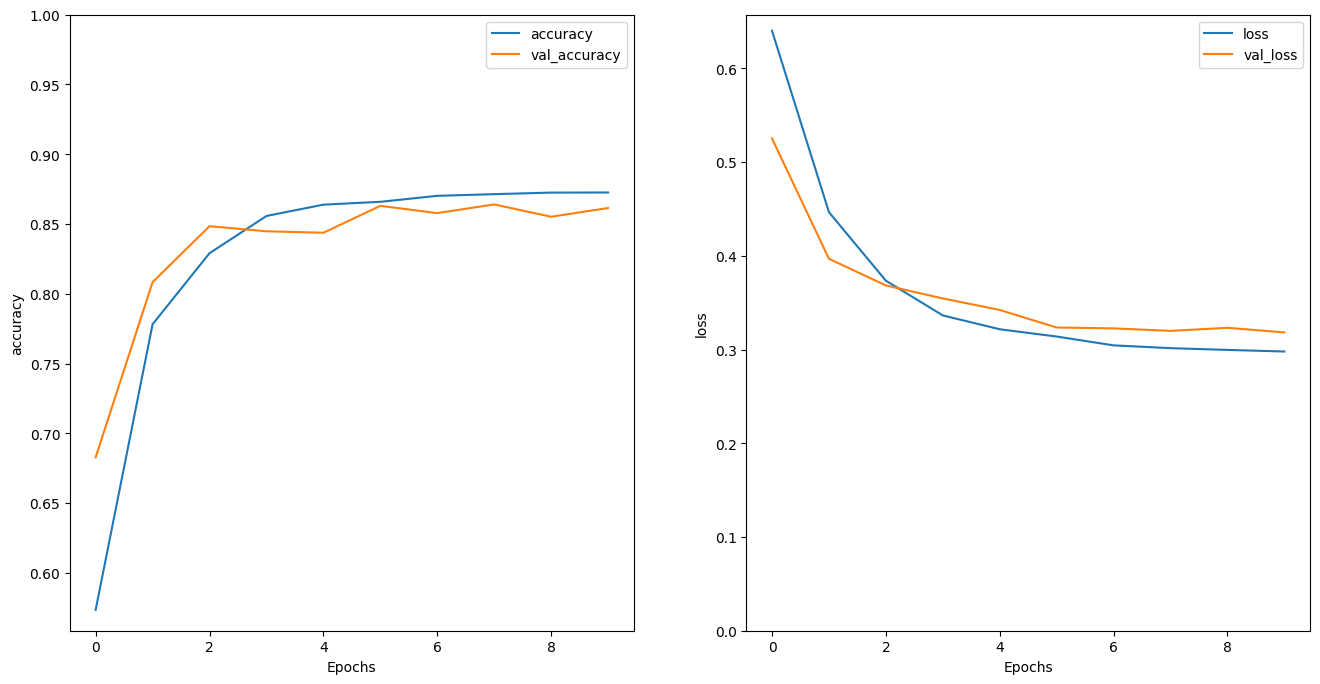

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [26]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text]).astype(object)

#predictions = model.predict(np.array([sample_text]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.81516296]
